# Multi-ancestry PRS
- **Version:** Python/3.9
- **Status:** COMPLETE
- **Last Updated:** 24-FEB-2025

## Notebook Overview
- Getting Started
    - Import python dependencies
    - Define helper functions
    - Print out versions of imported python dependencies
    - Load R dependencies
    - Define directories and ancestry lists
    - Install bioinformatics packages
- Process plink files
    - For Model 1
    - For Model 2
    - Get number of unrelated participants per ancestry
- Process Clinical Data
    - Generate covariates with PCs
    - Admixture
- Generate PCA plot
- Model 1
    - Generate Upset plot
    - Meta-analyze base data
    - Estimate PRS profiles
    - PRS vs. PD risk
    - Compare PCs vs Admixture
    - Plot ROC
    - Estimate Specificity and Sensitivity
- Model 2
    - PRSice
    - Heatmap comparing p-value thresholds
    - Estimate Specificity and Sensitivity
    - Plot ROC
- Compare Model 1 and Model 2
    - Compare AUCs between Model 1 and Model 2
    - Density plot
    - Forest plot
    - Estimate SNPs contributing most to PRS
- Foo et al. EAS Analysis

# Getting Started

## Import python dependencies

In [2]:
## Import the necessary python dependencies 
%pip install seaborn --upgrade
%load_ext rpy2.ipython
%pip install -U kaleido

from datetime import date
import importlib.metadata
from IPython.display import display
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, TwoSlopeNorm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
import numbers
import numpy as np
import os
import pandas as pd
import plotly.express as px
import requests
import scipy
from scipy import stats
from scipy.stats import norm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
import subprocess
import sys
import seaborn as sns
import types

today = date.today()
date = today.strftime("%d-%b-%Y").upper()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Define helper functions

In [22]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different imported names vs. system/pip names
        # Unfortunately, there is no systematic way to get pip names from a package's imported name. You'll have to add exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def compare_rocs(input_path, output_path, auc1_variable, auc2_variable, xlabel):
    # Read p-values matrix and rescale values
    df_pvals = pd.read_csv(input_path, sep="\t", index_col="Ancestry")
    df_pvals_log = np.log(-np.log(np.abs(df_pvals)) + 1) * df_pvals / np.abs(df_pvals)
    
    # Prepare formatting for heatmap
    max_abs = np.max(np.abs(df_pvals_log))
    norm = TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
    annot = df_pvals.map(lambda x: "*" if -0.05 <= x <= 0.05 else "")
    
    # Generate heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(df_pvals_log, cmap="RdBu", norm=norm, cbar=True, ax=ax, annot=annot, fmt="")
    
    # Format color bar
    cbar = ax.collections[0].colorbar
    cbar.set_label("")
    cbar.set_ticks([-1.38522686, 1.38522686])
    cbar.set_ticklabels([f"{auc1_variable} Significantly Better", f"{auc2_variable} Significantly Better"])
    
    # Label axes and save figure
    plt.xlabel(xlabel)
    plt.ylabel("Target data ancestry")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


## Print out versions of imported python dependencies

In [4]:
imports = list(set(get_imports()))
print(f"PACKAGE VERSIONS ({date})")
for m in importlib.metadata.distributions():
    if m.metadata["Name"] in imports and m.metadata["Name"]!="pip":
        print(f"\t{m.metadata['Name']}=={m.version}")


PACKAGE VERSIONS (22-FEB-2025)
	matplotlib==3.10.0
	pandas==2.2.3
	statsmodels==0.14.4
	matplotlib==3.7.3
	scipy==1.11.4
	pandas==2.0.3
	seaborn==0.13.2
	requests==2.32.3
	plotly==5.24.1
	scikit-learn==1.5.2
	numpy==1.25.2


## Load R dependencies

In [5]:
%%R

install.packages("caret")
install.packages("optparse", repos="https://cloud.r-project.org/")


* installing *source* package ‘caret’ ...
** package ‘caret’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Debian 10.2.1-6) 10.2.1 20210110’


gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/home/jranke/git/r-backports/bullseye/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c caret.c -o caret.o
gcc -shared -L/usr/lib/R/lib -Wl,-z,relro -o caret.so caret.o -L/usr/lib/R/lib -lR


installing to /home/jupyter/.R/library/00LOCK-caret/00new/caret/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (caret)
* installing *source* package ‘optparse’ ...
** package ‘optparse’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** exec
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if in

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/caret_7.0-1.tar.gz'
Content type 'application/x-gzip' length 2273919 bytes (2.2 MB)
downloaded 2.2 MB


The downloaded source packages are in
	‘/var/tmp/Rtmp07bfHH/downloaded_packages’
Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/optparse_1.7.5.tar.gz'
Content type 'application/x-gzip' length 41938 bytes (40 KB)
downloaded 40 KB


The downloaded source packages are in
	‘/var/tmp/Rtmp07bfHH/downloaded_packages’
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [6]:
%%R

require(data.table)
require(dplyr)
require(ggplot2)

library(optparse)
library(data.table)
library("ggplot2")
library(RColorBrewer)
library("caret")
library("pROC")


Loading required package: data.table
data.table 1.16.2 using 8 threads (see ?getDTthreads).  Latest news: r-datatable.com
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: lattice
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



## Define directories and ancestry lists

In [ ]:
WORK_DIR = "/home/jupyter"
RESULTS_DIR = "/home/jupyter/workspace/ws_files/results"
REL9_DIR = "/home/jupyter/workspace/gp2/release/path"
DATA_DIR = "/home/jupyter/workspace/ws_files/data"

ancestries = ["AAC", "AFR", "AJ", "AMR", "EAS", "EUR", "CAS"]
summstat_ancestries = ["AAC", "EAS", "EUR", "AMR"]


In [ ]:
%%R

WORK_DIR <- "/home/jupyter"
RESULTS_DIR <- "/home/jupyter/workspace/ws_files/results"
REL9_DIR <- "/home/jupyter/workspace/gp2/release/path"
DATA_DIR <- "/home/jupyter/workspace/ws_files/data"

ancestries <- list("AAC", "AFR", "AJ", "AMR", "EAS", "EUR", "CAS")
summstat_ancestries <- list("AAC","EAS","EUR","AMR")


In [9]:
if not os.path.exists(RESULTS_DIR):
    ! mkdir {RESULTS_DIR}
    for ancestry in ancestries:
        ! mkdir {RESULTS_DIR}/{ancestry}
        ! mkdir {RESULTS_DIR}/{ancestry}/model1_plink
        ! mkdir {RESULTS_DIR}/{ancestry}/model2_plink
        
    ! mkdir {RESULTS_DIR}/EAS_Foo
    ! mkdir {RESULTS_DIR}/meta/
    ! mkdir {RESULTS_DIR}/scores/
    ! mkdir {RESULTS_DIR}/density/
    ! mkdir {RESULTS_DIR}/roc/


## Install bioinformatics packages

In [10]:
%%bash

if test -e /home/jupyter/plink; then
    echo "Plink is already installed in /home/jupyter"
else
    echo "Plink is not installed"
    wget -P /home/jupyter http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20190304.zip 
    unzip -o /home/jupyter/plink_linux_x86_64_20190304.zip -d /home/jupyter
    rm /home/jupyter/plink_linux_x86_64_20190304.zip
fi

chmod u+x /home/jupyter/plink


Plink is already installed in /home/jupyter


In [11]:
%%bash

if test -e /home/jupyter/plink2; then
    echo "Plink2 is already installed in /home/jupyter"
else
    echo "Plink2 is not installed"
    wget -P /home/jupyter http://s3.amazonaws.com/plink2-assets/plink2_linux_x86_64_latest.zip
    unzip -o /home/jupyter/plink2_linux_x86_64_latest.zip -d /home/jupyter
    rm /home/jupyter/plink2_linux_x86_64_latest.zip
fi

chmod u+x /home/jupyter/plink2


Plink2 is already installed in /home/jupyter


In [12]:
%%bash

if test -e /home/jupyter/metal; then
    echo "Metal is already installed in /home/jupyter"
else
    echo "Metal is not installed"
    wget -P /home/jupyter https://csg.sph.umich.edu/abecasis/metal/download/Linux-metal.tar.gz
    tar --strip-components=1 -xzf /home/jupyter/Linux-metal.tar.gz -C /home/jupyter
    rm /home/jupyter/Linux-metal.tar.gz
fi

chmod u+x /home/jupyter/metal


Metal is already installed in /home/jupyter


In [13]:
%%bash

if test -e /home/jupyter/prsice; then
    echo "PRSice is already installed in /home/jupyter"
else
    echo "PRSice is not installed"
    wget -P /home/jupyter https://github.com/choishingwan/PRSice/releases/download/2.3.5/PRSice_linux.zip
    unzip -o /home/jupyter/PRSice_linux.zip -d /home/jupyter
    mv /home/jupyter/PRSice_linux /home/jupyter/prsice
fi

chmod u+x /home/jupyter/prsice


PRSice is already installed in /home/jupyter


# Process Plink Files

## For Model 1

### Find related individuals to be removed

In [ ]:
for ancestry in ancestries:
    df_related = pd.read_csv(f"{REL9_DIR}/meta_data/related_samples/{ancestry}_release9_vwb.related")
    related_ids = df_related["IID2"].str.replace(r"_s[12345]$", "", regex=True).drop_duplicates()
    related_ids.to_csv(f"{RESULTS_DIR}/{ancestry}/related.txt", index=False, header=False)


### Extract sex data

In [ ]:
df_masterkey = pd.read_csv(f"{REL9_DIR}/clinical_data/master_key_release9_final_vwb.csv")
df_sex = df_masterkey[['GP2ID', 'biological_sex_for_qc']].copy()
df_sex['biological_sex_for_qc'] = df_sex['biological_sex_for_qc'].replace({
    'Female':2, 
    'Male':1, 
    'Other/Unknown/Not Reported':0,
})
df_sex.insert(0, 'New_Column', 0)
df_sex.to_csv(f'{RESULTS_DIR}/sex.txt', index=False, header=False, sep = ' ')


### Create b-files with 90 risk variants extracted

In [ ]:
%%bash

for ANCESTRY in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    for CHRNUM in {1..22}; do
        /home/jupyter/plink2 \
        --pfile "/home/jupyter/workspace/gp2/release/path/imputed_genotypes/${ANCESTRY}/chr${CHRNUM}_${ANCESTRY}_release9_vwb" \
        --remove "/home/jupyter/workspace/ws_files/results/${ANCESTRY}/related.txt" \
        --update-sex "/home/jupyter/workspace/ws_files/results/sex.txt" \
        --extract range "/home/jupyter/workspace/ws_files/data/CHR_POS_HG38.txt"  \
        --make-bed \
        --out "/home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/chr${CHRNUM}_${ANCESTRY}"
    done
done


### Save names of files for each chromosome that have been generated for each ancestry

In [ ]:
%%bash

for ANCESTRY in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    > /home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/files.txt
    for CHRNUM in {1..22}; do
        BED_FILE="/home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/chr${CHRNUM}_${ANCESTRY}.bed"
        if [[ -f "${BED_FILE}" ]]; then
            echo "/home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/chr${CHRNUM}_${ANCESTRY}" >> /home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/files.txt
        fi
    done

    echo "Final list of files for ${ANCESTRY}:"
    cat /home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/files.txt 
done


### Merge chromosomes and remove duplicate IDs at the same position

In [ ]:
%%bash

for ANCESTRY in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    /home/jupyter/plink \
    --merge-list "/home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/files.txt" \
    --make-bed \
    --out "/home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/merged_${ANCESTRY}_orig"

    /home/jupyter/plink2 \
    --bfile "/home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/merged_${ANCESTRY}_orig" \
    --rm-dup force-first \
    --set-all-var-ids @:# \
    --make-bed \
    --out "/home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/merged_${ANCESTRY}"
    
    rm /home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/merged_${ANCESTRY}_orig*
done


## For Model 2

In [ ]:
%%bash

for ancestry in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    for chrnum in {1..22}; do
        /home/jupyter/plink2 \
        --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/${ancestry}/chr${chrnum}_${ancestry}_release9_vwb \
        --remove /home/jupyter/workspace/ws_files/results/${ancestry}/related.txt \
        --make-bed \
        --out /home/jupyter/workspace/ws_files/results/${ancestry}/model2_plink/chr${chrnum}
    done
done


## Get number of unrelated participants per ancestry

In [15]:
n_per_ancestry = {}
for ancestry in ancestries:
    df_participants = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/model1_plink/merged_{ancestry}.fam", sep="\t", header=None)
    df_participants = df_participants[df_participants[5].isin([1, 2])]
    n_per_ancestry[ancestry] = len(df_participants)
print(n_per_ancestry)


{'AAC': 1144, 'AFR': 2606, 'AJ': 1819, 'AMR': 3358, 'EAS': 4168, 'EUR': 31799, 'CAS': 905}


# Process Clinical Data

## Generate covariates with PCs

In [ ]:
# Load and merge master key
df_master = pd.read_csv(f"{REL9_DIR}/clinical_data/master_key_release9_final_vwb.csv")
df_master = df_master[["GP2ID","age_at_sample_collection","age_of_onset","biological_sex_for_qc","baseline_GP2_phenotype_for_qc"]]
df_master.reset_index(drop=True, inplace=True)
display(df_master)


In [ ]:
# Reformat sex column
df_sex = df_master[['GP2ID','biological_sex_for_qc']].copy()
df_sex['biological_sex_for_qc'] = df_sex['biological_sex_for_qc'].replace({
    'Female':2,
    'Male':1,
    'Other/Unknown/Not Reported':0,
})
df_sex.rename({"biological_sex_for_qc":"SEX"}, inplace=True, axis=1)
df_sex.insert(0, 'New_Column', 0)
df_sex.reset_index(drop=True, inplace=True)
display(df_sex)


In [ ]:
pcs = []
for ancestry in ancestries:
    pcs.append(pd.read_csv(f"{REL9_DIR}/raw_genotypes/{ancestry}/{ancestry}_release9_vwb.eigenvec", sep="\t"))
df_pcs = pd.concat(pcs)
df_pcs.drop("#FID", axis=1, inplace=True)
df_pcs.rename({"IID":"GP2ID"}, axis=1, inplace=True)
display(df_pcs)


In [ ]:
# Print demographic data for each ancestry
df_master_ages = df_master[["GP2ID","age_at_sample_collection","age_of_onset"]].copy()

df_ages_merged = []

for ancestry in ancestries:
    df_participants = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/model1_plink/merged_{ancestry}.fam", sep="\t", header=None)
    df_participants.rename(columns={1:"GP2ID", 4:"SEX", 5:"PHENO"}, inplace=True)
    df_participants = df_participants[["GP2ID", "SEX", "PHENO"]]
    df_participants = df_participants.merge(df_master_ages, on="GP2ID")
    df_participants["AGE"] = df_participants.apply(
        lambda row: row["age_of_onset"] if row["PHENO"] == 2 else row["age_at_sample_collection"], axis=1
    )
    df_participants["ANCESTRY"] = ancestry
    df_ages_merged.append(df_participants[["GP2ID","AGE","PHENO","ANCESTRY"]].copy())
    
    df_participants = df_participants[["GP2ID","SEX","PHENO","AGE"]]
    df_participants = df_participants[df_participants["PHENO"].isin([1, 2])]
    df_controls = df_participants[df_participants["PHENO"] == 1].copy()
    df_cases = df_participants[df_participants["PHENO"] == 2].copy()
    
    print(ancestry)
    print(f'Cases: {df_participants["PHENO"].value_counts()[2]}')
    print(f'Controls: {df_participants["PHENO"].value_counts()[1]}')
    print(f'Male: {df_participants["SEX"].value_counts()[1]}')
    print(f'Female: {df_participants["SEX"].value_counts()[2]}')
    print(f'Average Age Controls: {df_controls["AGE"].mean():.2f} +/- {df_controls["AGE"].std():.2f}')
    print(f'Average AAO Cases:    {df_cases["AGE"].mean():.2f} +/- {df_cases["AGE"].std():.2f}')
    print()


In [ ]:
df_ages_merged = pd.concat(df_ages_merged)
df_ages_merged.reset_index(drop=True, inplace=True)

df_ages_merged_cases = df_ages_merged[df_ages_merged["PHENO"] == 2].copy()
df_ages_merged_cases.fillna({"AGE":df_ages_merged_cases["AGE"].mean()}, inplace=True)
df_ages_merged_controls = df_ages_merged[df_ages_merged["PHENO"] != 2].copy()
df_ages_merged_controls.fillna({"AGE":df_ages_merged_controls["AGE"].mean()}, inplace=True)
df_ages_merged = pd.concat([df_ages_merged_cases, df_ages_merged_controls])
df_ages_merged = df_ages_merged[["GP2ID","AGE","ANCESTRY"]]

display(df_ages_merged)


In [ ]:
df_pheno = df_master[["GP2ID", "baseline_GP2_phenotype_for_qc"]].copy()
df_pheno.rename({"baseline_GP2_phenotype_for_qc":"PHENO"}, inplace=True, axis=1)
df_pheno["PHENO"] = df_pheno["PHENO"].replace({
    "PD": 2,
    "Control": 1,
    "Other": -9,
})
display(df_pheno)


In [ ]:
df_covar = df_sex.merge(df_ages_merged, on="GP2ID")
df_covar = df_covar.merge(df_pheno, on="GP2ID")
df_covar = df_covar.merge(df_pcs, on="GP2ID")
df_covar.to_csv(f'{RESULTS_DIR}/covariates_pheno.txt', index=False, sep = ' ')
df_covar.drop("PHENO", axis=1, inplace=True)
df_covar.to_csv(f'{RESULTS_DIR}/covariates.txt', index=False, sep = ' ')


## Admixture

In [ ]:
# Load covariate data
df_covar = pd.read_csv(f"{RESULTS_DIR}/covariates_pheno.txt", sep=" ")
df_covar.columns = ["FID", "IID", "SEX", "AGE", "ANCESTRY", "PHENO", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]

# Load admixture data and find IDs that do not correspond with covariate data
df_admixture = pd.read_csv(f"{REL9_DIR}/meta_data/admixture/GP2_release9_labeled_admixture_vwb.txt", sep="\t")
df_admixture["IID"] = df_admixture["IID"].str.replace(r"_s.*$", "", regex=True)
df_admixture = df_admixture.drop_duplicates(subset="IID")
ids_excluded = df_covar["IID"][~df_covar["IID"].isin(df_admixture["IID"])]

# Find a mapping for inconsistent IDs
df_master = pd.read_csv(f"{REL9_DIR}/clinical_data/master_key_release9_final_vwb.csv")
df_master = df_master[["GP2ID", "nba_GP2sampleID_r7"]]
df_master["nba_GP2sampleID_r7"] = df_master["nba_GP2sampleID_r7"].str.replace(r"_s.*$", "", regex=True)
df_master = df_master[df_master["GP2ID"].isin(ids_excluded)]
mapping_dict = df_master.set_index("nba_GP2sampleID_r7")["GP2ID"].to_dict()

# Apply the mapping to the admixture data
df_admixture["IID"] = df_admixture["IID"].map(mapping_dict).fillna(df_admixture["IID"])
df_admixture.to_csv(f"{RESULTS_DIR}/admixture.txt", index=False, sep="\t")


# Generate PCA plot

In [ ]:
df_covar = pd.read_csv(f"{RESULTS_DIR}/covariates_pheno.txt", sep="\s+")
df_covar = df_covar[df_covar["PHENO"].isin([1, 2])]
df_covar.rename(columns={"GP2ID":"IID"}, inplace=True)
df_covar = df_covar[["IID","ANCESTRY"]]
df_covar.replace({
    "AFR":"African",
    "AAC":"African Admixed",
    "EUR":"European",
    "AMR":"Latino / Admixed American",
    "AJ":"Ashkenazi Jewish",
    "CAS":"Central Asian",
    "EAS":"East Asian",
}, inplace=True)

df_ids_mapping = pd.read_csv(f"{DATA_DIR}/logging_updatedIDchanges.txt", sep="\t")
df_ids_mapping.rename(columns={"old_iid":"IID", "new_iid":"IID_new"}, inplace=True)
df_pcs = pd.read_csv(f"{REL9_DIR}/meta_data/qc_metrics/projected_pcs_vwb.csv")
df_pcs = df_pcs[["IID","PC1","PC2","PC3"]]
df_pcs = df_pcs.merge(df_ids_mapping, on="IID")
df_pcs = df_pcs[["IID_new","PC1","PC2","PC3"]]
df_pcs.rename(columns={"IID_new":"IID"}, inplace=True)
df_pcs = df_pcs.drop_duplicates(subset="IID")

df_covar = df_covar.merge(df_pcs, on="IID")
display(df_covar)


In [ ]:
fig = px.scatter_3d(
    df_covar,
    x="PC1",
    y="PC2",
    z="PC3",
    color="ANCESTRY",
    color_discrete_sequence=px.colors.qualitative.Bold,
)

fig.update_traces(marker={'size': 3})
fig.update_layout(
    legend=dict(
        font=dict(size=16),
        itemsizing="constant",
        tracegroupgap=5,
    ),
)
fig.show()
fig.write_image(f'{RESULTS_DIR}/supp_fig1.png', width=1980, height=1080)
fig.write_html(f'{RESULTS_DIR}/supp_fig1.html')


# Model 1

## Generate Upset plot

### Generate association summary stats

In [ ]:
%%bash

for ANCESTRY in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    /home/jupyter/plink \
    --bfile "/home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_plink/merged_${ANCESTRY}" \
    --assoc \
    --out "/home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1"
done


### Merge summary stats across ancestries

In [ ]:
df_merged = None
for ancestry in ["AAC","AFR","AMR","CAS","EAS","EUR","AJ"]:
    df = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/model1.assoc", sep="\s+")
    df["BETA"] = np.log(df["OR"] + 0.01)
    df = df[["SNP","A1","BETA","P"]]
    df.rename(columns={"A1":f"A1_{ancestry}", "BETA":f"BETA_{ancestry}", "P":f"P_{ancestry}"}, inplace=True)
    if df_merged is None:
        df_merged = df
    else:
        df_merged = df_merged.merge(df, on="SNP", how="outer")
    
df_merged[["CHR", "POS"]] = df_merged["SNP"].str.split(":", expand=True)
df_merged["POS"] = df_merged["POS"].astype(int)
df_merged["CHR"] = df_merged["CHR"].astype(int)
df_merged.sort_values(["CHR","POS"], inplace=True)
df_merged.drop(["CHR","POS"], axis=1, inplace=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged.to_csv(f"{RESULTS_DIR}/supp_tab3.txt", sep="\t", index=False)


### Flip signs where A1 is inconsistent

In [ ]:
df_merged_adjusted = df_merged.copy()
df_merged_adjusted["A1"] = np.nan
for ancestry in ancestries:
    df_merged_adjusted["A1"] = df_merged_adjusted["A1"].fillna(df_merged_adjusted[f"A1_{ancestry}"])
    
for ancestry in ancestries:
    mask = df_merged_adjusted[f"A1_{ancestry}"] != df_merged_adjusted["A1"]
    df_merged_adjusted.loc[mask, f"BETA_{ancestry}"] *= -1
df_merged_adjusted.drop("A1", axis=1, inplace=True)


### Melt dataset

In [ ]:
for ancestry in ancestries:
    df_merged_adjusted.rename(columns={f"BETA_{ancestry}":ancestry}, inplace=True)
    df_merged_adjusted.drop([f"A1_{ancestry}", f"P_{ancestry}"], axis=1, inplace=True)
    
df_upset_merged = df_merged_adjusted.melt(id_vars=["SNP"], var_name="ANC", value_name="BETA")[["ANC","SNP","BETA"]]
df_upset_merged['CHR'] = df_upset_merged['SNP'].str.extract(r'^(\d+)').astype(int)
df_upset_merged['BP'] = df_upset_merged['SNP'].str.extract(r'(\d+)$').astype(int)
df_upset_merged = df_upset_merged.sort_values(by=['CHR','BP','ANC'])
df_upset_merged.drop(["CHR", "BP"], axis=1, inplace=True)
df_upset_merged = df_upset_merged.reset_index(drop=True)
display(df_upset_merged)


### Generate Upset plot

In [ ]:
pal=["#6B1414","#C14E4E","#CF9FFF","#1E90FF", "#000000"]

# Want purple to be right at beta=0
quantiles = df_upset_merged["BETA"][df_upset_merged["BETA"] < 0].describe().loc[['min','50%']].tolist()
quantiles += [0]
quantiles += df_upset_merged["BETA"][df_upset_merged["BETA"] > 0].describe().loc[['50%', 'max']].tolist()
quantiles_norm = min_max_scale(quantiles)
cmp = LinearSegmentedColormap.from_list("", list(zip(quantiles_norm, pal)))


In [ ]:
fig, ax = plt.subplots(
    figsize=(30,3),
    sharex='col'
)
fig.clf()
gs = gridspec.GridSpec(1, 2, width_ratios=(30,0.7))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

sns.set_style({'font_scale': 2, 'axes.facecolor':'white', 'grid.color': '.8'})
sns.set_theme(style="white", palette=None)
plt.margins(x=0.01, y=0.05)
plt.subplots_adjust(wspace=0, hspace=0)
plot_bottom = sns.scatterplot(
    df_upset_merged,
    x='SNP',
    y='ANC',
    hue='BETA',
    s=200,
    edgecolor='black',
    palette=cmp,
    legend='brief',
    ax=ax1,
)
plot_bottom.spines["top"].set_visible(False) 
plot_bottom.spines["bottom"].set_visible(False) 
plot_bottom.spines["left"].set_visible(False) 
plot_bottom.spines["right"].set_visible(False) 
plot_bottom.set_xticklabels(df_upset_merged.drop_duplicates(subset='SNP')['SNP'], rotation=45, ha='right')
plot_bottom.get_legend().remove()
plot_bottom.axhspan(ymin=0.5, ymax=1.5, color='steelblue', alpha=0.1, lw=0)
plot_bottom.axhspan(ymin=2.5, ymax=3.5, color='steelblue', alpha=0.1, lw=0)
plot_bottom.axhspan(ymin=4.5, ymax=5.5, color='steelblue', alpha=0.1, lw=0)
plot_bottom.set_ylabel('')

sm = plt.cm.ScalarMappable(cmap=cmp)
sm.set_array([])

cb_ticks=[df_upset_merged['BETA'].min().round(2), 0, df_upset_merged['BETA'].max().round(2)]
cb = plt.colorbar(
    sm,
    cax=ax2,
    ticks=min_max_scale(cb_ticks),
)
cb.ax.set_yticklabels(cb_ticks) 
cb.outline.set_color('black')
cb.outline.set_linewidth(1)
cb.ax.tick_params(labelsize=10, pad=15, width=0)
cb.ax.set_title('Beta', size=15, pad=10)

fig.savefig(f'{RESULTS_DIR}/figure2.png',facecolor='white', dpi=300, bbox_inches = "tight")


## Meta-analyze Base Data

### Generate metaGWAS - summary statistics for EAS (Foo + 23andMe)

In [ ]:
%%R

## Extract 90 SNPs from Foo et al. 
sumstats <- fread(paste0(DATA_DIR, "/6724PDcases-24851controls-5843213snps-summary-stats-metaP-SE.txt"), header =T)
SNPs <- fread(paste0(DATA_DIR, "/90riskloci.txt"), header =T)
total <- merge(sumstats, SNPs, by="BP")
output <- total[,c("SNP.y","BETA", "SE", "P", "A1", "A2")]
write.table(output, file = paste0(RESULTS_DIR, "/scores/Foo_90riskloci.txt"), quote = F, row.names = F, sep = "\t")


In [ ]:
%%R

## Extract 90 SNPs from 23andMe EAS
sumstats <- fread(paste0(DATA_DIR, "/filtered_sumstats_23andme_EASTASIAN_PD.hg19.txt"), header =T)
SNPs <- fread(paste0(DATA_DIR, "/90riskloci.txt"), header =T)
names(SNPs)[3] <- "position"
total <- merge(sumstats, SNPs, by="position")
output <- total[,c("SNP","effect", "stderr", "pvalue", "effect_allele", "alt_allele")]
write.table(output, file = paste0(RESULTS_DIR, "/scores/23andMe_EASTASIAN_90riskloci.txt"), quote = F, row.names = F, sep = "\t")


In [ ]:
%%bash

## Now meta-analyze
/home/jupyter/metal
SCHEME STDERR
GENOMICCONTROL ON

# === DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER SNP.y
ALLELE A1 A2
EFFECT BETA
STDERR SE
PVALUE P
PROCESS /home/jupyter/workspace/ws_files/results/scores/Foo_90riskloci.txt

# === DESCRIBE AND PROCESS THE SECOND INPUT FILE ===
MARKER SNP
ALLELE effect_allele alt_allele
EFFECT effect
STDERR stderr
PVALUE pvalue
PROCESS /home/jupyter/workspace/ws_files/results/scores/23andMe_EASTASIAN_90riskloci.txt

OUTFILE /home/jupyter/workspace/ws_files/results/meta/ASIAN .tbl
ANALYZE HETEROGENEITY
QUIT


In [ ]:
%%bash

## Remove SNPs only present in one of the datasets
grep -v "?" /home/jupyter/workspace/ws_files/results/meta/ASIAN1.tbl > /home/jupyter/workspace/ws_files/results/temp


In [ ]:
%%R

## Now convert all to hg38
sumstats <- fread(paste0(RESULTS_DIR, "/temp"), header =T)
SNPs <- fread(paste0(DATA_DIR, "/90riskloci_38.txt"), header =T)
names(SNPs)[1] <- "MarkerName"
total <- merge(sumstats, SNPs, by="MarkerName")
total$A1cap <- toupper(total$Allele1)
output <- total[,c("markerID","A1cap", "Effect")]
write.table(output, file = paste0(RESULTS_DIR, "/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt"), quote = F, col.names = FALSE, row.names = F, sep = "\t")


### Generate metaGWAS - summary statistics for AMR (Loesch + 23andMe)

In [ ]:
%%R

## Extract 90 SNPs from Loesch et al. 
sumstats <- fread(paste0(DATA_DIR, "/Loesch_et_al_2021_Latam_no23andme_hg38.txt"), header =T)
SNPs <- fread(paste0(DATA_DIR, "/90riskloci_38.txt"), header =T)
names(sumstats)[4] <- "BP"
total <- merge(sumstats, SNPs, by="BP")
total$SE <- total$beta/total$Score
output <- total[,c("markerID", "beta", "SE", "Score.pval", "ref", "alt")]
write.table(output, file = paste0(RESULTS_DIR, "/scores/Loesch_90riskloci.txt"), quote = F, row.names = F, sep = "\t")


In [ ]:
%%R

## Extract 90 SNPs from 23andMe LATINO
sumstats <- fread(paste0(DATA_DIR, "/filtered_sumstats_23andme_LATINO_PD.txt"), header =T)
SNPs <- fread(paste0(DATA_DIR, "/90riskloci_38.txt"), header =T)
names(SNPs)[3] <- "position"
total <- merge(sumstats, SNPs, by="position")
output <- total[,c("markerID", "effect", "stderr", "pvalue", "effect_allele", "alt_allele")]
write.table(output, file = paste0(RESULTS_DIR, "/scores/23andMe_LATINO_90riskloci.txt"), quote = F, row.names = F, sep = "\t")


In [ ]:
%%bash

## Now meta-analyze
/home/jupyter/metal
SCHEME STDERR
GENOMICCONTROL ON

# === DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER markerID
ALLELE ref alt
EFFECT beta
STDERR SE
PVALUE Score.pval
PROCESS /home/jupyter/workspace/ws_files/results/scores/Loesch_90riskloci.txt

# === DESCRIBE AND PROCESS THE SECOND INPUT FILE ===
MARKER markerID
ALLELE effect_allele alt_allele
EFFECT effect
STDERR stderr
PVALUE pvalue
PROCESS /home/jupyter/workspace/ws_files/results/scores/23andMe_LATINO_90riskloci.txt

OUTFILE /home/jupyter/workspace/ws_files/results/meta/LATINO .tbl
ANALYZE HETEROGENEITY

QUIT


In [ ]:
%%bash

## Remove SNPs only present in one of the datasets
grep -v "?" /home/jupyter/workspace/ws_files/results/meta/LATINO1.tbl > /home/jupyter/workspace/ws_files/results/temp


In [ ]:
%%R

## Now extract columns for score file
sumstats <- fread(paste0(RESULTS_DIR, "/temp"), header =T)
sumstats$A1cap <- toupper(sumstats$Allele1)
output <- sumstats[,c("MarkerName","A1cap", "Effect")]
write.table(output, file = paste0(RESULTS_DIR, "/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt"), quote = F, col.names = FALSE, row.names = F, sep = "\t")


In [ ]:
! rm {RESULTS_DIR}/temp


## Estimate PRS profiles

### Estimate profiles

In [ ]:
%%bash

for ancestry in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    /home/jupyter/plink \
    --bfile "/home/jupyter/workspace/ws_files/results/${ancestry}/model1_plink/merged_${ancestry}" \
    --score "/home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt" \
    --out "/home/jupyter/workspace/ws_files/results/${ancestry}/model1_AAC"
done


In [ ]:
%%bash

for ancestry in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    /home/jupyter/plink \
    --bfile "/home/jupyter/workspace/ws_files/results/${ancestry}/model1_plink/merged_${ancestry}" \
    --score "/home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt" \
    --out "/home/jupyter/workspace/ws_files/results/${ancestry}/model1_EAS"
done


In [ ]:
%%bash

for ancestry in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    /home/jupyter/plink \
    --bfile "/home/jupyter/workspace/ws_files/results/${ancestry}/model1_plink/merged_${ancestry}" \
    --score "/home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt" \
    --out "/home/jupyter/workspace/ws_files/results/${ancestry}/model1_AMR"
done


In [ ]:
%%bash

for ancestry in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    /home/jupyter/plink \
    --bfile "/home/jupyter/workspace/ws_files/results/${ancestry}/model1_plink/merged_${ancestry}" \
    --score "/home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt" \
    --out "/home/jupyter/workspace/ws_files/results/${ancestry}/model1_EUR"
done


### Valid predictors

In [ ]:
%%bash

ANCESTRIES=("EUR" "AAC" "AMR" "EAS" "AFR" "AJ" "CAS")
SUMMSTAT_ANCESTRIES=("EUR" "AAC" "AMR" "EAS")
OUTPUT_FILE="/home/jupyter/workspace/ws_files/results/supp_tab2.txt"

echo -e "Cohort\tSummary Statistics\tN" > $OUTPUT_FILE

for ANCESTRY in "${ANCESTRIES[@]}"; do
    for SUMMSTAT_ANCESTRY in "${SUMMSTAT_ANCESTRIES[@]}"; do
        COUNT=$(grep "valid predictors" /home/jupyter/workspace/ws_files/results/${ANCESTRY}/model1_${SUMMSTAT_ANCESTRY}.log | awk '{print $2}')
        echo -e "${ANCESTRY}\t${SUMMSTAT_ANCESTRY}\t${COUNT}" >> ${OUTPUT_FILE}
    done
done


## PRS vs PD Risk

### Adjust by PCs

In [32]:
%%R

for (ancestry in ancestries) {
    print(paste0("------------------------------", ancestry, "------------------------------"))
    forest <- list()
    for (summstat_ancestry in summstat_ancestries) {
        print(paste0(summstat_ancestry, " Summary stats"))
        temp_data <- read.table(paste0(RESULTS_DIR, "/", ancestry, "/model1_", summstat_ancestry, ".profile"), header = T) 
        temp_covs <- read.table(paste0(RESULTS_DIR, "/covariates.txt"), header = T, sep=" ")
        colnames(temp_covs) <- c("FID", "IID", "SEX", "AGE", "ANCESTRY", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10")
        data <- merge(temp_data, temp_covs, by = "IID")
        data$CASE <- data$PHENO - 1
        
        dat <- subset(data, CASE != -10) 
        meanPop <- mean(subset(dat, CASE == 0)$SCORE)
        sdPop <- sd(subset(dat, CASE == 0)$SCORE)
        dat$zSCORE <- (dat$SCORE - meanPop)/sdPop
        
        grsTests <- glm(CASE ~ zSCORE + SEX + AGE + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data = dat, family='binomial')
        print(summary(grsTests))
        grs_summary <- summary(grsTests)$coefficients
        conf_intervals <- confint(grsTests, level = 0.95)
        zscore_summary <- grs_summary["zSCORE", , drop = FALSE]
        zscore_conf <- conf_intervals["zSCORE", , drop = FALSE]
        zscore <- as.data.table(cbind(summstat_ancestry, zscore_summary, zscore_conf))
        colnames(zscore) <- c("COHORT", "BETA", "SE", "T", "P", "L95", "U95")
        zscore <- zscore[, !"T", with = FALSE]
        forest <- rbind(forest, zscore)
    }
    print("Merged")
    print(forest)
    fwrite(forest, paste0(RESULTS_DIR, "/", ancestry, "/forest_risk_pcs_", ancestry, ".txt"), sep = "\t", col.names = TRUE, quote = FALSE)
}


[1] "------------------------------AAC------------------------------"
[1] "AAC Summary stats"

Call:
glm(formula = CASE ~ zSCORE + SEX + AGE + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10, family = "binomial", 
    data = dat)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.083442   0.476518   4.372 1.23e-05 ***
zSCORE        0.199900   0.071590   2.792  0.00523 ** 
SEX          -0.653243   0.146144  -4.470 7.83e-06 ***
AGE          -0.034019   0.006715  -5.066 4.06e-07 ***
PC1         -17.334728   2.565804  -6.756 1.42e-11 ***
PC2         -11.951764   2.638407  -4.530 5.90e-06 ***
PC3          -0.331229   4.123361  -0.080  0.93597    
PC4           0.314532   3.591190   0.088  0.93021    
PC5          -7.017291   4.057954  -1.729  0.08376 .  
PC6          -1.950201   3.850930  -0.506  0.61256    
PC7           6.421741   4.055667   1.583  0.11333    
PC8          -0.928432   2.963519  -0.313  0.75406    
PC9         -13.708800  

Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be 

### Adjust by Admixture

In [33]:
%%R

for (ancestry in ancestries) {
    print(paste0("------------------------------", ancestry, "------------------------------"))
    forest <- list()
    i <- 1
    for (summstat_ancestry in summstat_ancestries) {
        print(paste0(summstat_ancestry, " Summary stats"))
        
        temp_data <- read.table(paste0(RESULTS_DIR, "/", ancestry, "/model1_", summstat_ancestry, ".profile"), header = T) 
        temp_covs <- read.table(paste0(RESULTS_DIR, "/covariates.txt"), header = T, sep=" ")
        admixture <- read.table(paste0(REL9_DIR, "/meta_data/admixture/GP2_release9_labeled_admixture_vwb.txt"), header = T, sep="\t")
        colnames(temp_covs) <- c("FID", "IID", "SEX", "AGE", "ANCESTRY", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10")
        covs <- merge(temp_covs, admixture, by = "IID")
        data <- merge(temp_data, covs, by = "IID")
        
        data$CASE <- data$PHENO - 1
        cases <- subset(data, CASE != -10)
        
        meanPop <- mean(subset(data, CASE == 0)$SCORE)
        sdPop <- sd(subset(data, CASE == 0)$SCORE)
        cases$zSCORE <- (cases$SCORE - meanPop)/sdPop
        
        grsTests <- glm(CASE ~ zSCORE + SEX + AGE + AJ + EUR + EAS + AMR + AFR + CAS + AAC, data = cases, family='binomial')
        print(summary(grsTests))
        grs_summary <- summary(grsTests)$coefficients
        conf_intervals <- confint(grsTests, level = 0.95)
        zscore_summary <- grs_summary["zSCORE", , drop = FALSE]
        zscore_conf <- conf_intervals["zSCORE", , drop = FALSE]
        zscore <- as.data.table(cbind(summstat_ancestry, zscore_summary, zscore_conf))
        colnames(zscore) <- c("COHORT", "BETA", "SE", "T", "P", "L95", "U95")
        zscore <- zscore[, !"T", with = FALSE]
        forest <- rbind(forest, zscore)
        i <- i + 1
    }
    print("Merged")
    print(forest)
    fwrite(forest, paste0(RESULTS_DIR, "/", ancestry, "/forest_risk_admixture_", ancestry, ".txt"), sep = "\t", col.names = TRUE, quote = FALSE)
}


[1] "------------------------------AAC------------------------------"
[1] "AAC Summary stats"

Call:
glm(formula = CASE ~ zSCORE + SEX + AGE + AJ + EUR + EAS + AMR + 
    AFR + CAS + AAC, family = "binomial", data = cases)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  14.866903   7.522071   1.976  0.04811 *  
zSCORE        0.190725   0.071355   2.673  0.00752 ** 
SEX          -0.647314   0.145827  -4.439 9.04e-06 ***
AGE          -0.034346   0.006621  -5.187 2.14e-07 ***
AJ           33.101387  20.458608   1.618  0.10567    
EUR         -32.399701  38.110514  -0.850  0.39524    
EAS           8.795826  17.877709   0.492  0.62272    
AMR         -10.309898   7.890333  -1.307  0.19133    
AFR         -14.468987   7.518182  -1.925  0.05429 .  
CAS         -31.871583  20.382568  -1.564  0.11790    
AAC         -48.470555  14.613010  -3.317  0.00091 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial

Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be done...
Waiting for profiling to be 

## Compare PCs vs Admixture

### Heatmap

In [34]:
df_heatmap = []
for ancestry in ["EUR","AJ","AFR","AAC","EAS","AMR","CAS"]:
    df_pcs = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/forest_risk_pcs_{ancestry}.txt", sep="\t")
    df_pcs[ancestry] = df_pcs["BETA"] / df_pcs["SE"]
    df_pcs = df_pcs[["COHORT", ancestry]]
    df_pcs = df_pcs.set_index("COHORT").T
    df_pcs.rename(columns={"AAC":"AFR"}, inplace=True)
    df_pcs = df_pcs.add_prefix("PCs adjusted - ")

    df_admixture = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/forest_risk_admixture_{ancestry}.txt", sep="\t")
    df_admixture[ancestry] = df_admixture["BETA"] / df_admixture["SE"]
    df_admixture = df_admixture[["COHORT", ancestry]]
    df_admixture = df_admixture.set_index("COHORT").T
    df_admixture.rename(columns={"AAC":"AFR"}, inplace=True)
    df_admixture = df_admixture.add_prefix("% admixture adjusted - ")
    
    df_merged = pd.concat([df_pcs, df_admixture], axis=1)
    df_merged = df_merged[[
        "PCs adjusted - EUR",
        "% admixture adjusted - EUR",
        "PCs adjusted - AMR",
        "% admixture adjusted - AMR",
        "PCs adjusted - EAS",
        "% admixture adjusted - EAS",
        "PCs adjusted - AFR",
        "% admixture adjusted - AFR",
    ]]
    df_heatmap.append(df_merged)
    
df_heatmap = pd.concat(df_heatmap)
df_heatmap = df_heatmap.rename_axis("Ancestry")


### Table

In [18]:
df_comparison = []
for ancestry in ["EUR","AJ","AFR","AAC","EAS","AMR","CAS"]:
    df_pcs = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/forest_risk_pcs_{ancestry}.txt", sep="\t")
    df_pcs_copy = df_pcs.copy()
    df_pcs["OR PCs"] = df_pcs.apply(lambda row: f"{math.e ** row['BETA']:.2f} ({math.e ** row['L95']:.2f} - {math.e ** row['U95']:.2f})", axis=1)
    df_pcs.rename(columns={"COHORT":"Summary Statistics", "P":"p-value PCs"}, inplace=True)
    df_pcs["Cohort"] = ancestry
    df_pcs = df_pcs[["Cohort","Summary Statistics","OR PCs","p-value PCs"]]
    
    df_admixture = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/forest_risk_admixture_{ancestry}.txt", sep="\t")
    df_admixture_copy = df_admixture.copy()
    df_admixture["OR Admixture"] = df_admixture.apply(lambda row: f"{math.e ** row['BETA']:.2f} ({math.e ** row['L95']:.2f} - {math.e ** row['U95']:.2f})", axis=1)
    df_admixture.rename(columns={"COHORT":"Summary Statistics", "P":"p-value Admixture"}, inplace=True)
    df_admixture["Cohort"] = ancestry
    df_admixture = df_admixture[["Cohort","Summary Statistics","OR Admixture","p-value Admixture"]]
    
    df_merged = df_pcs.merge(df_admixture, on=["Cohort","Summary Statistics"])
    df_merged = df_merged[[
        "Cohort",
        "Summary Statistics",
        "OR PCs",
        "OR Admixture",
        "p-value PCs",
        "p-value Admixture",
    ]]
    
    se = np.sqrt(df_pcs_copy["SE"]**2 + df_admixture_copy["SE"]**2)
    zsc = (df_pcs_copy["BETA"] - df_admixture_copy["BETA"]) / se
    p_val = 2 * (1 - norm.cdf(abs(zsc)))
    df_merged["Z-test p-value"] = p_val
    
    df_comparison.append(df_merged)

df_comparison = pd.concat(df_comparison)
df_comparison.to_csv(f"{RESULTS_DIR}/supp_tab4.txt", index=False, sep="\t")
    

In [18]:
for ancestry in ["EUR","AJ","AFR","AAC","EAS","AMR","CAS"]:
    df_pcs = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/forest_risk_pcs_{ancestry}.txt", sep="\t")
    display(df_pcs.head())
    df_admixture = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/forest_risk_admixture_{ancestry}.txt", sep="\t")
    display(df_admixture.head())
    print()
    

,COHORT,BETA,SE,P,L95,U95
0,AAC,0.190180,0.012637,3.491510e-51,0.165435,0.214973
1,EAS,0.291309,0.012783,5.909320e-115,0.266289,0.316399
2,EUR,0.454128,0.013027,3.014658e-266,0.428663,0.479730
3,AMR,0.233717,0.012649,3.149376e-76,0.208954,0.258538


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.188220,0.012615,2.442923e-50,0.163518,0.212971
1,EAS,0.290926,0.012767,6.228952e-115,0.265937,0.315986
2,EUR,0.453222,0.013017,1.309766e-265,0.427777,0.478803
3,AMR,0.233004,0.012633,5.865307e-76,0.208272,0.257795


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.171124,0.054650,1.740384e-03,0.064316,0.278677
1,EAS,0.155076,0.054728,4.603042e-03,0.048038,0.262687
2,EUR,0.504081,0.055957,2.091678e-19,0.396679,0.616080
3,AMR,0.127315,0.054657,1.984090e-02,0.020337,0.234715


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.182991,0.054739,8.288801e-04,0.076043,0.290751
1,EAS,0.158086,0.054601,3.787798e-03,0.051317,0.265465
2,EUR,0.505984,0.055984,1.596651e-19,0.398574,0.618078
3,AMR,0.126016,0.054461,2.067360e-02,0.019423,0.233028


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.285881,0.046961,1.145591e-09,0.194264,0.378413
1,EAS,0.250155,0.044722,2.224774e-08,0.162846,0.338224
2,EUR,0.289287,0.046477,4.835645e-10,0.198569,0.380824
3,AMR,0.087905,0.045079,5.117356e-02,-0.000366,0.176407


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.249585,0.045727,4.812328e-08,0.160313,0.339626
1,EAS,0.215792,0.043870,8.702441e-07,0.130099,0.302134
2,EUR,0.256924,0.045502,1.638337e-08,0.168065,0.346501
3,AMR,0.079476,0.044332,7.301321e-02,-0.007347,0.166495


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.199900,0.071590,5.233867e-03,0.059854,0.340751
1,EAS,0.306921,0.075080,4.352844e-05,0.160714,0.455306
2,EUR,0.438817,0.074292,3.490723e-09,0.294534,0.586067
3,AMR,0.192475,0.072909,8.292548e-03,0.050045,0.336103


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.190725,0.071355,7.520088e-03,0.051158,0.331136
1,EAS,0.299387,0.074917,6.434816e-05,0.153495,0.447439
2,EUR,0.436627,0.074512,4.633087e-09,0.291954,0.584324
3,AMR,0.173210,0.072632,1.709014e-02,0.031307,0.316281


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.150946,0.040951,2.277589e-04,0.070827,0.231395
1,EAS,0.239424,0.041741,9.700467e-09,0.157860,0.321530
2,EUR,0.383342,0.041613,3.197596e-20,0.302164,0.465329
3,AMR,0.131139,0.040924,1.353358e-03,0.051071,0.211538


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.200649,0.035308,1.324638e-08,0.131634,0.270074
1,EAS,0.224689,0.036113,4.911433e-10,0.154121,0.295717
2,EUR,0.375408,0.036285,4.362181e-25,0.304632,0.446904
3,AMR,0.130431,0.035255,2.158734e-04,0.061449,0.199679


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.191868,0.040147,1.760799e-06,0.113388,0.270813
1,EAS,0.369734,0.042551,3.653002e-18,0.286765,0.453622
2,EUR,0.513111,0.041435,3.213652e-35,0.432739,0.595211
3,AMR,0.306740,0.043393,1.561822e-12,0.222023,0.392178


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.224607,0.037798,2.809854e-09,0.150774,0.298982
1,EAS,0.340443,0.039498,6.737567e-18,0.263391,0.418267
2,EUR,0.510930,0.038913,2.219273e-39,0.435422,0.587999
3,AMR,0.222026,0.040071,3.010809e-08,0.143732,0.300857


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.226077,0.077404,0.003492,0.075344,0.379083
1,EAS,0.210761,0.076653,0.005968,0.061196,0.361994
2,EUR,0.364008,0.079144,0.000004,0.210088,0.520669
3,AMR,0.295371,0.077121,0.000128,0.145242,0.447890


,COHORT,BETA,SE,P,L95,U95
0,AAC,0.216594,0.076368,0.004566,0.067852,0.367537
1,EAS,0.221514,0.074888,0.003097,0.075478,0.369342
2,EUR,0.338520,0.077545,0.000013,0.187625,0.491933
3,AMR,0.278911,0.076485,0.000266,0.129932,0.430082


## Plot ROC

In [37]:
%%R

for (ancestry in ancestries) {
    print(paste0("--------------------", ancestry, "--------------------"))
    to_plot <- list()
    for (summstat_ancestry in summstat_ancestries) {
        data <- read.table(paste0(RESULTS_DIR, "/", ancestry, "/model1_", summstat_ancestry, ".profile"), header = T) 
        data$CASE <- data$PHENO - 1
        dat <- subset(data, CASE != -10)
        Model <- glm(CASE ~ SCORE, data = dat, family = 'binomial')
        dat$probDisease <- predict(Model, dat, type = c("response"))
        dat$predicted <- ifelse(dat$probDisease > 0.5, "DISEASE", "CONTROL")
        dat$reported <- ifelse(dat$CASE == 1, "DISEASE","CONTROL")
        dat$Group <- summstat_ancestry
        to_plot <- rbind(to_plot, dat)
    }
    write.table(to_plot, file = paste0(RESULTS_DIR, "/", ancestry, "/model1_risk_results.txt"), sep = "\t", quote = FALSE, row.names = FALSE)
}


[1] "--------------------AAC--------------------"
[1] "--------------------AFR--------------------"
[1] "--------------------AJ--------------------"
[1] "--------------------AMR--------------------"
[1] "--------------------EAS--------------------"
[1] "--------------------EUR--------------------"
[1] "--------------------CAS--------------------"


In [38]:
for ancestry in ancestries:
    print(f"-------------------- {ancestry} --------------------")
    to_plot = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/model1_risk_results.txt", sep="\t")
    
    # Plot ROC curves
    plt.figure(figsize=(8, 5))
    for group in to_plot["Group"].unique():
        group_data = to_plot[to_plot["Group"] == group]
        fpr, tpr, _ = roc_curve(group_data["CASE"], group_data["probDisease"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{group} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {ancestry}")
    plt.legend(loc="lower right")
    output_path = f"{RESULTS_DIR}/supp_fig2_{ancestry}.png"
    plt.savefig(output_path, dpi=300)
    plt.close()


-------------------- AAC --------------------
-------------------- AFR --------------------
-------------------- AJ --------------------
-------------------- AMR --------------------
-------------------- EAS --------------------
-------------------- EUR --------------------
-------------------- CAS --------------------


## Estimate Specificity and Sensitivity

In [39]:
%%R

for (summstat_ancestry in summstat_ancestries) {
    print(paste0("------------------------------", summstat_ancestry, "------------------------------"))
    
    # Initialize results data.table
    results_dt <- data.table(Ancestry = ancestries)
    results_dt[, AUC := as.numeric(NA)]
    results_dt[, Accuracy := as.numeric(NA)]
    results_dt[, CI_Lower := as.numeric(NA)]
    results_dt[, CI_Upper := as.numeric(NA)]
    results_dt[, Balanced_Accuracy := as.numeric(NA)]
    results_dt[, Sensitivity := as.numeric(NA)]
    results_dt[, Specificity := as.numeric(NA)]
    
    for (ancestry in ancestries) {
        dat <- read.table(paste0(RESULTS_DIR, "/", ancestry, "/model1_", summstat_ancestry, ".profile"), header = T)
        dat$CASE <- dat$PHENO - 1
        dat <- subset(dat, CASE != -10)
        meanControls <- mean(dat$SCORE[dat$CASE == 0])
        sdControls <- sd(dat$SCORE[dat$CASE == 0])
        dat$zSCORE <- (dat$SCORE - meanControls)/sdControls
        grsTests <- glm(CASE ~ zSCORE, family="binomial", data = dat)
        
        dat$probDisease <- predict(grsTests, dat, type = c("response"))
        dat$reported <- ifelse(dat$CASE == 1, "DISEASE", "CONTROL")
        roc <- roc(response = dat$reported, predictor = dat$probDisease)
        auc_value <- auc(roc)
        
        result.coords <- coords(
            roc, 
            "best", 
            best.method = "closest.topleft", 
            ret = c("threshold", "accuracy", "specificity", "sensitivity", "youden"),
        )
        
        dat$predicted <- ifelse(dat$probDisease > result.coords$threshold, "DISEASE", "CONTROL")
        confMat <- confusionMatrix(data = as.factor(dat$predicted), reference = as.factor(dat$reported), positive = "DISEASE")
        results_dt[Ancestry == ancestry, AUC := auc_value]
        results_dt[Ancestry == ancestry, Accuracy := confMat$overall["Accuracy"]]
        results_dt[Ancestry == ancestry, CI_Lower := confMat$overall["AccuracyLower"]]
        results_dt[Ancestry == ancestry, CI_Upper := confMat$overall["AccuracyUpper"]]
        results_dt[Ancestry == ancestry, Balanced_Accuracy := confMat$byClass["Balanced Accuracy"]]
        results_dt[Ancestry == ancestry, Sensitivity := confMat$byClass["Sensitivity"]]
        results_dt[Ancestry == ancestry, Specificity := confMat$byClass["Specificity"]]
        
        dat$ancestry <- ancestry
        dat$sumstat <- summstat_ancestry
    }

    fwrite(results_dt, paste0(RESULTS_DIR, "/", summstat_ancestry, "_results.txt"), sep = "\t", quote = FALSE, row.names = FALSE)
    print(results_dt)
    print(noquote(""))
}


[1] "------------------------------AAC------------------------------"
   Ancestry       AUC  Accuracy  CI_Lower  CI_Upper Balanced_Accuracy
     <list>     <num>     <num>     <num>     <num>             <num>
1:      AAC 0.5851752 0.5646853 0.5353824 0.5936547         0.5706960
2:      AFR 0.5434991 0.5402916 0.5209291 0.5595636         0.5373158
3:       AJ 0.5433305 0.5035734 0.4803316 0.5268036         0.5348708
4:      AMR 0.5791882 0.5613460 0.5443662 0.5782189         0.5628159
5:      EAS 0.5796702 0.5575816 0.5423473 0.5727351         0.5597993
6:      EUR 0.5542992 0.5306456 0.5251421 0.5361436         0.5393554
7:      CAS 0.5569510 0.5624309 0.5293984 0.5950558         0.5530172
   Sensitivity Specificity
         <num>       <num>
1:   0.5846154   0.5567766
2:   0.5262055   0.5484262
3:   0.4763610   0.5933806
4:   0.5529046   0.5727273
5:   0.5772402   0.5423585
6:   0.5169963   0.5617144
7:   0.5859107   0.5201238
[1] 
[1] "------------------------------EAS--------------

Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Sett

In [40]:
df_model1 = []
abbr = ["AAC","EAS","EUR","AMR"]
for i, summstat_ancestry in enumerate(summstat_ancestries):
    df = pd.read_csv(f"{RESULTS_DIR}/{summstat_ancestry}_results.txt", sep="\s+")
    df.insert(1, "Summary statistics", abbr[i])
    df_model1.append(df)
df_model1 = pd.concat(df_model1)
numeric_cols = ["AUC", "Accuracy", "CI_Lower", "CI_Upper", "Balanced_Accuracy", "Sensitivity", "Specificity"]
df_model1[numeric_cols] = df_model1[numeric_cols].round(3)
df_model1["Accuracy"] = df_model1.apply(lambda row: f"{row['Accuracy']:.3f} ({row['CI_Lower']:.3f} - {row['CI_Upper']:.3f})", axis=1)
df_model1.drop(columns=["CI_Lower", "CI_Upper"], inplace=True)
df_model1.sort_values(["Ancestry","Summary statistics"], inplace=True)
df_model1.to_csv(f"{RESULTS_DIR}/table2.txt", index=False, sep="\t")


In [24]:
%%R

non_eur_sumstat_ancestries <- list("AAC", "AMR", "EAS")

# Initialize results data.table
results_dt <- data.table(Ancestry = ancestries)
for (non_eur_sumstat_ancestry in non_eur_sumstat_ancestries) {
    results_dt[[paste0(non_eur_sumstat_ancestry, " vs. EUR")]] <- as.numeric(NA)
}

for (ancestry in ancestries) {
    print(paste0("------------------------------", ancestry, "------------------------------"))
    model1_data_full <- read.table(paste0(RESULTS_DIR, "/", ancestry, "/model1_risk_results.txt"), header = TRUE) 
    
    for (non_eur_sumstat_ancestry in non_eur_sumstat_ancestries) {
        sumstat1_data <- subset(model1_data_full, Group == non_eur_sumstat_ancestry)
        sumstat2_data <- subset(model1_data_full, Group == "EUR")
        
        gt1 <- sumstat1_data$CASE
        gt2 <- sumstat2_data$CASE
        pred_ss1 <- sumstat1_data$probDisease
        pred_ss2 <- sumstat2_data$probDisease
        roc1 <- roc(gt1, pred_ss1)
        roc2 <- roc(gt2, pred_ss2)        
        
        auc1 <- auc(roc1)
        auc2 <- auc(roc2)
        results <- roc.test(roc1, roc2, method = "delong")
        
        p_value <- as.numeric(results$p.value)
        if (auc1 > auc2) {
            p_value <- p_value * -1
        }
        print(paste0("--------------------", non_eur_sumstat_ancestry, " vs. EUR --------------------"))
        print(p_value)
        
        # Store numeric p-value in the correct row and column
        results_dt[Ancestry == ancestry, paste0(non_eur_sumstat_ancestry, " vs. EUR") := p_value]
    }
}

fwrite(results_dt, paste0(RESULTS_DIR, "/model1_comparison.txt"), sep = "\t", quote = FALSE, row.names = FALSE)


[1] "------------------------------AAC------------------------------"
[1] "--------------------AAC vs. EUR --------------------"
[1] 0.000851787
[1] "--------------------AMR vs. EUR --------------------"
[1] 5.388729e-05
[1] "--------------------EAS vs. EUR --------------------"
[1] 0.08645032
[1] "------------------------------AFR------------------------------"
[1] "--------------------AAC vs. EUR --------------------"
[1] -0.5016517
[1] "--------------------AMR vs. EUR --------------------"
[1] 0.03654276
[1] "--------------------EAS vs. EUR --------------------"
[1] -0.9648708
[1] "------------------------------AJ------------------------------"
[1] "--------------------AAC vs. EUR --------------------"
[1] 1.568025e-11
[1] "--------------------AMR vs. EUR --------------------"
[1] 9.093203e-15
[1] "--------------------EAS vs. EUR --------------------"
[1] 4.60068e-12
[1] "------------------------------AMR------------------------------"
[1] "--------------------AAC vs. EUR ----------

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


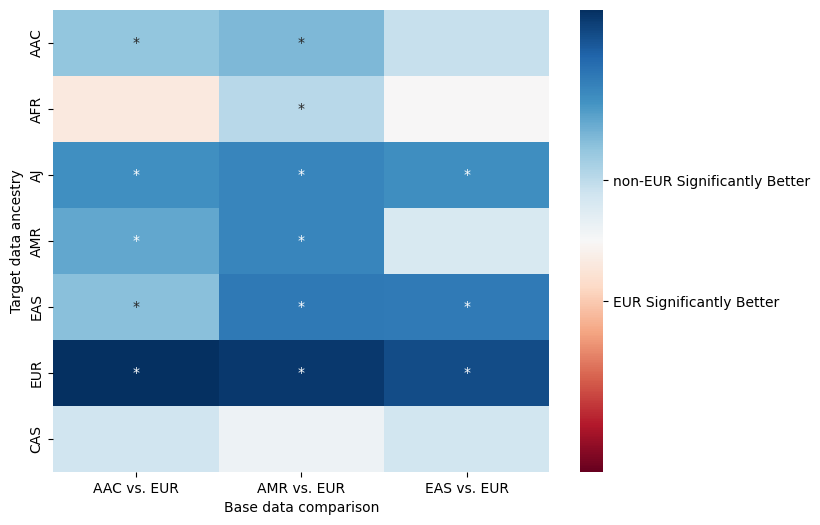

In [26]:
compare_rocs(
    f"{RESULTS_DIR}/model1_comparison.txt", 
    f"{RESULTS_DIR}/supp_fig3.png", 
    "EUR", 
    "non-EUR",
    "Base data comparison",
)


# Model 2

## PRSice

### Format covars

In [ ]:
df_covar = pd.read_csv(f"{RESULTS_DIR}/covariates.txt", sep='\s+')
df_covar.drop(["New_Column", "ANCESTRY"], axis=1, inplace=True)
df_covar.rename({"GP2ID":"IID"}, inplace=True, axis=1)
df_covar.to_csv(f"{RESULTS_DIR}/covariates_prs.txt", sep="\t", index=False)
df_covar


### Run PRSice

In [13]:
%%bash

for ancestry in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    Rscript /home/jupyter/PRSice.R \
    --out /home/jupyter/workspace/ws_files/results/${ancestry}/model2_${ancestry} \
    --target /home/jupyter/workspace/ws_files/results/${ancestry}/model2_plink/chr# \
    -b /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta \
    --snp SNP \
    --A1 A1 \
    --A2 A2 \
    --stat BETA \
    --pvalue P \
    --ld /home/jupyter/workspace/ws_files/results/${ancestry}/model2_plink/chr# \
    --print-snp \
    --score con-std \
    --perm 10000 \
    --prsice /home/jupyter/prsice \
    -n 24 \
    --binary-target T \
    --quantile 4 \
    --prevalence 0.005 \
    --bar-levels 5e-2,5e-3,5e-4,5e-5,5e-6,5e-7,5e-8 \
    --fastscore \
    --no-full \
    --multi-plot 10 \
    --thread 16 \
    --cov-file /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --seed 3 \
    --ignore-fid
done


PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 15:21:18
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-08,5e-07,5e-06,5e-05,0.0005,0.005,0.05 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/AAC/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out /home/jupyter/workspace/ws_files/results/AAC/model2_AAC \
    --perm 10000 \
    --prevalence 0.005 

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/AAC/model2_AAC
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf
PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 15:28:50
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-08,5e-07,5e-06,5e-05,0.0005,0.005,0.05 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/AFR/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out 

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/AFR/model2_AFR
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf
PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 15:40:22
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-08,5e-07,5e-06,5e-05,0.0005,0.005,0.05 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/AJ/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out /

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/AJ/model2_AJ
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf
PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 15:46:36
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-08,5e-07,5e-06,5e-05,0.0005,0.005,0.05 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/AMR/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out 

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/AMR/model2_AMR
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf
PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 15:59:21
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-08,5e-07,5e-06,5e-05,0.0005,0.005,0.05 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/EAS/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out 

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/EAS/model2_EAS
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf
PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 16:12:33
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-08,5e-07,5e-06,5e-05,0.0005,0.005,0.05 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/EUR/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out 

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/CAS/model2_CAS
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf


In [14]:
%%bash

Rscript /home/jupyter/PRSice.R \
--out /home/jupyter/workspace/ws_files/results/EUR/model2_EUR \
--target /home/jupyter/workspace/ws_files/results/EUR/model2_plink/chr# \
-b /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
--beta \
--snp SNP \
--A1 A1 \
--A2 A2 \
--stat BETA \
--pvalue P \
--ld /home/jupyter/workspace/ws_files/results/EUR/model2_plink/chr# \
--print-snp \
--score con-std \
--perm 10000 \
--prsice /home/jupyter/prsice \
-n 24 \
--binary-target T \
--quantile 4 \
--prevalence 0.005 \
--bar-levels 5e-2,5e-3,5e-4,5e-5,5e-6,5e-7,5e-8 \
--fastscore \
--no-full \
--multi-plot 10 \
--thread 16 \
--cov-file /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
--seed 3 \
--ignore-fid \
--extract /home/jupyter/workspace/ws_files/results/EUR/model2_EUR.valid


PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 16:27:34
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-08,5e-07,5e-06,5e-05,0.0005,0.005,0.05 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --extract /home/jupyter/workspace/ws_files/results/EUR/model2_EUR.valid \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/EUR/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out /home/jupyter/workspac

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/EUR/model2_EUR
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf


### Find best PRSice model

In [16]:
for ancestry in ancestries:
    df_prsice = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/model2_{ancestry}.prsice", sep="\t")
    df_prsice = df_prsice[df_prsice["Num_SNP"] < n_per_ancestry[ancestry]] 
    threshold = df_prsice.sort_values(by='R2', ascending=False)["Threshold"].iloc[0]
    print(f"{ancestry}: {threshold}")
    

AAC: 5e-08
AFR: 5e-07
AJ: 5e-06
AMR: 5e-08
EAS: 5e-08
EUR: 5e-07
CAS: 5e-06


### Re-run PRSice with best p-threshold for each ancestry

In [17]:
%%bash

i=0
thresholds=(5e-08 5e-07 5e-06 5e-08 5e-08 5e-07 5e-06)
for ancestry in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    Rscript /home/jupyter/PRSice.R \
    --out /home/jupyter/workspace/ws_files/results/${ancestry}/model2_${ancestry}_best \
    --target /home/jupyter/workspace/ws_files/results/${ancestry}/model2_plink/chr# \
    -b /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta \
    --snp SNP \
    --A1 A1 \
    --A2 A2 \
    --stat BETA \
    --pvalue P \
    --ld /home/jupyter/workspace/ws_files/results/${ancestry}/model2_plink/chr# \
    --print-snp \
    --score con-std \
    --perm 10000 \
    --prsice /home/jupyter/prsice \
    -n 24 \
    --binary-target T \
    --quantile 4 \
    --prevalence 0.005 \
    --bar-levels ${thresholds[i]} \
    --fastscore \
    --no-full \
    --multi-plot 10 \
    --cov-file /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --seed 3 \
    --thread 16 \
    --ignore-fid
    
    ((i++))
done


PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 17:50:34
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-08 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/AAC/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out /home/jupyter/workspace/ws_files/results/AAC/model2_AAC_best \
    --perm 10000 \
    --prevalence 0.005 \
    --print-snp  \
    --pval

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/AAC/model2_AAC_best
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf
PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 17:53:58
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-07 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/AFR/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out /home/jupyter/workspace/ws_files/res

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/AFR/model2_AFR_best
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf
PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 17:57:41
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-06 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/AJ/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out /home/jupyter/workspace/ws_files/resu

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/AJ/model2_AJ_best
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf
PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 17:59:52
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-08 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/AMR/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out /home/jupyter/workspace/ws_files/res

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/AMR/model2_AMR_best
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf
PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 18:03:23
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-08 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/EAS/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out /home/jupyter/workspace/ws_files/res

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/EAS/model2_EAS_best
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf
PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 18:06:21
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-07 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/EUR/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out /home/jupyter/workspace/ws_files/res

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/EUR/model2_EUR_best
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf
PRSice 2.3.5 (2021-09-20) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2025-02-11 18:11:51
/home/jupyter/prsice \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 5e-06 \
    --base /home/jupyter/workspace/ws_files/data/multi_MAMA.txt \
    --beta  \
    --binary-target T \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov /home/jupyter/workspace/ws_files/results/covariates_prs.txt \
    --fastscore  \
    --ignore-fid  \
    --ld /home/jupyter/workspace/ws_files/results/CAS/model2_plink/chr# \
    --no-full  \
    --num-auto 22 \
    --out /home/jupyter/workspace/ws_files/res

Begin plotting
Current Rscript version = 2.3.3
Plotting the quantile plot
Will not generate the quantile plot for  /home/jupyter/workspace/ws_files/results/CAS/model2_CAS_best
Plotting Bar Plot
Plotting Multi-Set-Plot


Warning message:
In max(pheno$Pheno, na.rm = T) :
  no non-missing arguments to max; returning -Inf


## Estimate Specificity and Sensitivity

In [43]:
%%R

# Initialize results data.table
results_dt <- data.table(Ancestry = ancestries)
results_dt[, AUC := as.numeric(NA)]
results_dt[, Accuracy := as.numeric(NA)]
results_dt[, CI_Lower := as.numeric(NA)]
results_dt[, CI_Upper := as.numeric(NA)]
results_dt[, Balanced_Accuracy := as.numeric(NA)]
results_dt[, Sensitivity := as.numeric(NA)]
results_dt[, Specificity := as.numeric(NA)]

for (ancestry in ancestries) {
    print(ancestry)

    dat <- read.table(paste0(RESULTS_DIR, "/", ancestry, "/model2_", ancestry, "_best.best"), header = TRUE, sep = " ")
    cov <- read.table(paste0(RESULTS_DIR, "/covariates_pheno.txt"), header = TRUE, sep = " ")
    
    colnames(cov) <- c("FID", "IID", "SEX", "AGE", "ANCESTRY", "PHENO", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10")
    dat <- merge(dat, cov, by = "IID")
    dat$CASE <- dat$PHENO - 1
    dat <- subset(dat, CASE != -10)
    meanControls <- mean(dat$PRS[dat$CASE == 0])
    sdControls <- sd(dat$PRS[dat$CASE == 0])
    dat$zSCORE <- (dat$PRS - meanControls) / sdControls
    grsTests <- glm(CASE ~ zSCORE, family = "binomial", data = dat)
    dat$probDisease <- predict(grsTests, dat, type = "response")
    dat$reported <- ifelse(dat$CASE == 1, "DISEASE", "CONTROL")
    roc <- roc(response = dat$reported, predictor = dat$probDisease)
    auc_value <- auc(roc)
    
    result.coords <- coords(
        roc, 
        "best", 
        best.method = "closest.topleft", 
        ret = c("threshold", "accuracy", "specificity", "sensitivity", "youden"),
    )
    
    dat$predicted <- ifelse(dat$probDisease > result.coords$threshold, "DISEASE", "CONTROL")
    confMat <- confusionMatrix(data = as.factor(dat$predicted), reference = as.factor(dat$reported), positive = "DISEASE")
    
    results_dt[Ancestry == ancestry, AUC := auc_value]
    results_dt[Ancestry == ancestry, Accuracy := confMat$overall["Accuracy"]]
    results_dt[Ancestry == ancestry, CI_Lower := confMat$overall["AccuracyLower"]]
    results_dt[Ancestry == ancestry, CI_Upper := confMat$overall["AccuracyUpper"]]
    results_dt[Ancestry == ancestry, Balanced_Accuracy := confMat$byClass["Balanced Accuracy"]]
    results_dt[Ancestry == ancestry, Sensitivity := confMat$byClass["Sensitivity"]]
    results_dt[Ancestry == ancestry, Specificity := confMat$byClass["Specificity"]]
}

fwrite(results_dt, paste0(RESULTS_DIR, "/model2_results.txt"), sep = "\t", quote = FALSE, row.names = FALSE)
print(results_dt)


[1] "AAC"
[1] "AFR"
[1] "AJ"
[1] "AMR"
[1] "EAS"
[1] "EUR"
[1] "CAS"
   Ancestry       AUC  Accuracy  CI_Lower  CI_Upper Balanced_Accuracy
     <list>     <num>     <num>     <num>     <num>             <num>
1:      AAC 0.5913966 0.5611888 0.5318693 0.5901929         0.5793895
2:      AFR 0.5831696 0.5763622 0.5571217 0.5954310         0.5682021
3:       AJ 0.6695295 0.6173722 0.5945871 0.6397780         0.6345511
4:      AMR 0.6391026 0.6045265 0.5877548 0.6211160         0.6077351
5:      EAS 0.5775092 0.5556622 0.5404226 0.5708237         0.5558018
6:      EUR 0.6210634 0.5976918 0.5922777 0.6030880         0.5863640
7:      CAS 0.6123701 0.6044199 0.5717123 0.6364455         0.5980632
   Sensitivity Specificity
         <num>       <num>
1:   0.6215385   0.5372405
2:   0.5377358   0.5986683
3:   0.6024355   0.6666667
4:   0.5860996   0.6293706
5:   0.5568994   0.5547041
6:   0.6154438   0.5572842
7:   0.6202749   0.5758514


Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases


In [16]:
df_bestfit = pd.read_csv(f"{RESULTS_DIR}/model2_results.txt", sep="\s+")
df_bestfit[["AUC","Accuracy","CI_Lower","CI_Upper","Balanced_Accuracy","Sensitivity","Specificity"]] = df_bestfit[["AUC","Accuracy","CI_Lower","CI_Upper","Balanced_Accuracy","Sensitivity","Specificity"]].round(3).astype(str)
df_bestfit["Accuracy"] = df_bestfit.apply(lambda row: f"{row['Accuracy']} ({row['CI_Lower']} - {row['CI_Upper']})", axis=1)
df_bestfit.rename(columns={"Accuracy":"Accuracy (95% CI)", "Balanced_Accuracy":"Balanced Accuracy"}, inplace=True)
df_bestfit.drop(["CI_Lower", "CI_Upper"], inplace=True, axis=1)

df_prsice = []
for ancestry in ancestries:
    df = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/model2_{ancestry}_best.summary", sep="\s+")
    df["Ancestry"] = ancestry
    df = df[[
        "Ancestry",
        "Threshold",
        "PRS.R2.adj",
        "Full.R2",
        "Null.R2",
        "Coefficient",
        "Standard.Error",
        "Num_SNP",
    ]]
    df.rename(columns={
        "PRS.R2.adj":"PRS R2 Adj",
        "Full.R2":"Full R2",
        "Null.R2":"Null R2",
        "Standard.Error":"SE",
        "Num_SNP":"No. of SNP",
    }, inplace=True)
    lower = f"{math.e ** (df.loc[0,'Coefficient'] - 1.96 * df.loc[0,'SE']):.2f}"
    upper = f"{math.e ** (df.loc[0,'Coefficient'] + 1.96 * df.loc[0,'SE']):.2f}"
    df["OR (95% CI)"] = f"{math.e ** df.loc[0,'Coefficient']:.2f} ({lower} - {upper})"
    df_prsice.append(df)
df_prsice = pd.concat(df_prsice)
df_prsice[["PRS R2 Adj","Full R2","Null R2","Coefficient","SE"]] = df_prsice[["PRS R2 Adj","Full R2","Null R2","Coefficient","SE"]].round(3)
df_prsice["Threshold"] = df_prsice["Threshold"].apply(lambda x: f'{x:.2e}')

df_merged = df_prsice.merge(df_bestfit, on="Ancestry")
df_merged.to_csv(f"{RESULTS_DIR}/table3.txt", index=False, sep="\t")
    

## Plot ROC

In [45]:
%%R

data_list <- list()
i <- 1
for (ancestry in ancestries) {
    print(paste0("------------------------------", ancestry, "------------------------------"))
    
    prs_data <- fread(paste0(RESULTS_DIR, '/', ancestry,'/model2_', ancestry, '_best.best'), header=T)
    colnames(prs_data)[4] <- "PRS"
    covar <- fread(paste0(RESULTS_DIR, "/covariates_pheno.txt"), header=T)
    colnames(covar)[1] <- "FID"
    colnames(covar)[2] <- "IID"
    temp <- merge(prs_data, covar, by = c("FID","IID"))
    temp$CASE <- temp$PHENO - 1
    DATA <- subset(temp, CASE != -10)

    ## Probability of disease calculation
    Model <- glm(CASE ~ PRS, data = DATA, family = "binomial")
    DATA$probDisease <- predict(Model, DATA, type = c("response"))
    DATA$predicted <- ifelse(DATA$probDisease > 0.5, "DISEASE", "CONTROL")
    DATA$reported <- ifelse(DATA$CASE == 1, "DISEASE","CONTROL")

    dat <- DATA
    dat$Group.name <- paste0("Model 2 ", ancestry)
    dat$Group <- "Model 2"
    data_list[[i]] <- dat
    i <- i + 1
}

to_plot <- rbindlist(data_list, fill = TRUE)
write.table(to_plot, file = paste0(RESULTS_DIR, "/model2_risk_results.txt"), sep = "\t", quote = FALSE, row.names = FALSE)


[1] "------------------------------AAC------------------------------"
[1] "------------------------------AFR------------------------------"
[1] "------------------------------AJ------------------------------"
[1] "------------------------------AMR------------------------------"
[1] "------------------------------EAS------------------------------"
[1] "------------------------------EUR------------------------------"
[1] "------------------------------CAS------------------------------"


In [46]:
to_plot = pd.read_csv(f"{RESULTS_DIR}/model2_risk_results.txt", sep="\t")
plt.figure(figsize=(8, 5))
ancestry_groups = to_plot['Group.name'].unique()
for ancestry_group in ancestry_groups:
    group_data = to_plot[to_plot['Group.name'] == ancestry_group]
    fpr, tpr, _ = roc_curve(group_data["CASE"], group_data["probDisease"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{ancestry_group} (AUC = {roc_auc:.2f})')

sns.set_palette("Dark2")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curves by Group")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig(f"{RESULTS_DIR}/figure4.png", dpi=300)
plt.close()


# Compare Model 1 and Model 2

## Compare AUCs between Model 1 and Model 2

In [42]:
%%R

summstat_list <- c("AAC", "EAS", "EUR", "AMR")

# Initialize results data.table
results_dt <- data.table(Ancestry = ancestries)
for (summstat in summstat_list) {
    results_dt[[summstat]] <- as.numeric(NA)
}

model2_data_full <- fread(paste0(RESULTS_DIR, "/model2_risk_results.txt"), header = TRUE)
for (ancestry in ancestries) {
    print(paste0("------------------------------", ancestry, "------------------------------"))
    model1_data_full <- read.table(paste0(RESULTS_DIR, "/", ancestry, "/model1_risk_results.txt"), header = TRUE) 
    
    for (summstat_ancestry in summstat_list) {
        model1_data <- subset(model1_data_full, Group == summstat_ancestry)
        model2_data <- subset(model2_data_full, ANCESTRY == ancestry)
        
        gt_m1 <- model1_data$CASE
        gt_m2 <- model2_data$CASE
        pred_m1 <- model1_data$probDisease
        pred_m2 <- model2_data$probDisease
        roc1 <- roc(gt_m1, pred_m1)
        roc2 <- roc(gt_m2, pred_m2)        
        
        auc1 <- auc(roc1)
        auc2 <- auc(roc2)
        results <- roc.test(roc1, roc2, method = "delong")
        
        p_value <- as.numeric(results$p.value)
        if (auc1 > auc2) {
            p_value <- p_value * -1
        }
        print(paste0("--------------------", summstat_ancestry, "--------------------"))
        print(p_value)
        print(auc1)
        print(auc2)
        
        results_dt[Ancestry == ancestry, (summstat_ancestry) := p_value]
    }
}

fwrite(results_dt, paste0(RESULTS_DIR, "/m1_m2_comparison.txt"), sep = "\t", quote = FALSE, row.names = FALSE)
print(results_dt)


[1] "------------------------------AAC------------------------------"
[1] "--------------------AAC--------------------"
[1] 0.8163538
Area under the curve: 0.5852
Area under the curve: 0.5914
[1] "--------------------EAS--------------------"
[1] -0.2451266
Area under the curve: 0.6217
Area under the curve: 0.5914
[1] "--------------------EUR--------------------"
[1] -0.02163641
Area under the curve: 0.6506
Area under the curve: 0.5914
[1] "--------------------AMR--------------------"
[1] 0.5369458
Area under the curve: 0.5751
Area under the curve: 0.5914
[1] "------------------------------AFR------------------------------"
[1] "--------------------AAC--------------------"
[1] 0.01553902
Area under the curve: 0.5435
Area under the curve: 0.5832
[1] "--------------------EAS--------------------"
[1] 0.004326059
Area under the curve: 0.5361
Area under the curve: 0.5832
[1] "--------------------EUR--------------------"
[1] 0.003719084
Area under the curve: 0.5356
Area under the curve: 0.583

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


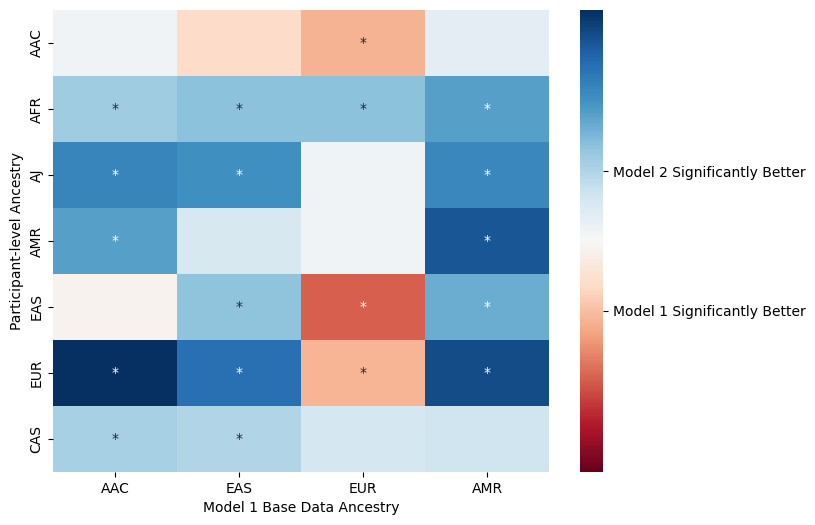

In [43]:
compare_rocs(
    f"{RESULTS_DIR}/m1_m2_comparison.txt", 
    f"{RESULTS_DIR}/figure5.png", 
    "Model 1", 
    "Model 2", 
    "Model 1 Base Data Ancestry", 
)


## Density plot

In [49]:
%%R

model2_full <- fread(paste0(RESULTS_DIR, "/model2_risk_results.txt"), select = c("CASE", "probDisease", "Group", "Group.name"))
for (ancestry in ancestries) {
    model1_to_plot <- fread(paste0(RESULTS_DIR, "/", ancestry, "/model1_risk_results.txt"), select = c("CASE", "probDisease", "Group"))
    model2_to_plot <- subset(model2_full, Group.name == paste0("Model 2 ", ancestry))
    model2_to_plot[,Group.name:=NULL]
    
    to_plot <- rbind(model1_to_plot, model2_to_plot)    
    
    to_plot_cases <- subset(to_plot, CASE == 1)
    density_rocs_plot <- ggplot(to_plot_cases, aes(probDisease, color=Group)) + geom_density(alpha = 0.5) + theme_bw()
    ggsave(plot = density_rocs_plot, filename = paste0(RESULTS_DIR, "/supp_fig5_", ancestry, ".png"), width = 8, height = 5, units = "in", dpi = 300)
}


## Forest plot

In [71]:
%%R

for (ancestry in ancestries) {
    level_order <- c('Model 1 (EUR)', 'Model 1 (EAS)', 'Model 1 (AMR)', 'Model 1 (AAC)', 'Model 2')
    model1 <- fread(paste0(RESULTS_DIR, "/", ancestry, "/forest_risk_pcs_", ancestry, ".txt"))
    model1[, COHORT := paste0("Model 1 (", COHORT, ")")]
    model2 <- fread(paste0(RESULTS_DIR, "/", ancestry, "/model2_", ancestry, "_best.prsice"))
    model2$COHORT <- 'Model 2'
    model2$L95 <- model2$Coefficient - 1.96 * model2$Standard.Error
    model2$U95 <- model2$Coefficient + 1.96 * model2$Standard.Error
    cols_to_keep <- c("COHORT", "Coefficient", "Standard.Error", "P", "L95", "U95")
    model2 <- model2[, ..cols_to_keep]
    colnames(model2) <- c("COHORT", "BETA", "SE", "P", "L95", "U95")
    dat <- rbind(model1, model2)
    
    plot <- ggplot(
        data=dat, 
        aes(
            x = factor(COHORT,levels = level_order),
            y = BETA,
            ymin = U95,
            ymax = L95,
            color = COHORT,
        ),
    ) +
    geom_pointrange(
        aes(ymin = L95, ymax = U95),
        cex = 0.7,
    ) +
    geom_hline(
        yintercept = 0,
        linetype = 2
    ) +
    scale_color_manual(
        values = c(
            "Model 2" = "#FF0000", 
            "Model 1 (EUR)" = "#0000FF", 
            "Model 1 (EAS)" = "#0000FF", 
            "Model 1 (AMR)" = "#0000FF", 
            "Model 1 (AAC)" = "#0000FF"
        ),
        guide = "none",
    ) +
    theme(
        plot.title = element_text(size = 20, face = "bold"),
        axis.text.y = element_text(size = 8, face = 'bold'),
        axis.ticks.y = element_blank(),
        axis.text.x = element_text(face="bold"),
        axis.title = element_text(size = 16, face="bold"),
        legend.position = "none",
    ) +
    xlab(' ') +
    ylab("Beta coefficient") +
    coord_flip() +
    theme_minimal() +
    ggtitle(paste0(ancestry, " - Individual level data - GP2 release 9")) +
    theme(plot.title = element_text(hjust=0.5))

    ggsave(
        paste0(RESULTS_DIR, "/figure3_", ancestry, ".jpg"), 
        plot = plot,
        width = 8, 
        height = 5, 
        units = "in",
        dpi = 500,
    )
}


## Estimate SNPs contributing most to PRS

In [27]:
%%bash

for ancestry in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    /home/jupyter/plink2 \
    --bfile /home/jupyter/workspace/ws_files/results/${ancestry}/model1_plink/merged_${ancestry} \
    --score /home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt list-variants \
    --extract /home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt \
    --export A --export-allele /home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt \
    --out /home/jupyter/workspace/ws_files/results/${ancestry}/bestsnps_AAC
done


PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/AAC/bestsnps_AAC.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/AAC/model1_plink/merged_AAC
  --export A
  --export-allele /home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/AAC/bestsnps_AAC
  --score /home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt list-variants

Start time: Wed Feb 12 14:36:34 2025
12984 MiB RAM detected, ~3323 available; reserving 3259 MiB for main workspace.
Using up to 2 compute threads.
1196 samples (698 females, 498 males; 1196 founders) loaded from
/home/jupyter/workspace/ws_files/results/AAC/model1_plink/merged_AAC.fam.
90 variants loaded from
/home/jupyter/workspace/ws_fil

/home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt was skipped
due to a missing variant ID.


--score: 83 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/EAS/bestsnps_AAC.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/EAS/bestsnps_AAC.sscore .
End time: Wed Feb 12 14:36:39 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EUR/bestsnps_AAC.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/EUR/model1_plink/merged_EUR
  --export A
  --export-allele /home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/EUR/bestsnps_AAC
  --score /home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt list-variants

Start time: Wed Feb 12 14:36:39 2025
12984 MiB RAM detected, ~3308 availab

In [28]:
%%bash

for ancestry in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    /home/jupyter/plink2 \
    --bfile /home/jupyter/workspace/ws_files/results/${ancestry}/model1_plink/merged_${ancestry} \
    --score /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt list-variants \
    --extract /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt \
    --export A --export-allele /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt \
    --out /home/jupyter/workspace/ws_files/results/${ancestry}/bestsnps_EAS
done


PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/AAC/bestsnps_EAS.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/AAC/model1_plink/merged_AAC
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/AAC/bestsnps_EAS
  --score /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt list-variants

Start time: Wed Feb 12 14:37:02 2025
12984 MiB RAM detected, ~3269 available; reserving 3205 MiB for main workspace.
Using up to 2 compute threads.
1196 samples (698 females, 498 males; 1196 founders) loaded from
/home/jupyter/workspace/ws_files/results/AAC/mo

/home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 64 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/AAC/bestsnps_EAS.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/AAC/bestsnps_EAS.sscore .
End time: Wed Feb 12 14:37:02 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/AFR/bestsnps_EAS.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/AFR/model1_plink/merged_AFR
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/AFR/bestsnps_EAS
  --score /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt list-var

/home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 64 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/AFR/bestsnps_EAS.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/AFR/bestsnps_EAS.sscore .
End time: Wed Feb 12 14:37:03 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/AJ/bestsnps_EAS.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/AJ/model1_plink/merged_AJ
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/AJ/bestsnps_EAS
  --score /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt list-variant

/home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 64 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/AJ/bestsnps_EAS.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/AJ/bestsnps_EAS.sscore .
End time: Wed Feb 12 14:37:04 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/AMR/bestsnps_EAS.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/AMR/model1_plink/merged_AMR
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/AMR/bestsnps_EAS
  --score /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt list-varia

/home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 64 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/AMR/bestsnps_EAS.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/AMR/bestsnps_EAS.sscore .
End time: Wed Feb 12 14:37:05 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS/bestsnps_EAS.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/EAS/model1_plink/merged_EAS
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/EAS/bestsnps_EAS
  --score /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt list-var

/home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
was skipped due to a missing variant ID.


--score: 64 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/EAS/bestsnps_EAS.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/EAS/bestsnps_EAS.sscore .
End time: Wed Feb 12 14:37:06 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EUR/bestsnps_EAS.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/EUR/model1_plink/merged_EUR
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/EUR/bestsnps_EAS
  --score /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt list-var

/home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 64 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/EUR/bestsnps_EAS.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/EUR/bestsnps_EAS.sscore .
End time: Wed Feb 12 14:37:07 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/CAS/bestsnps_EAS.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/CAS/model1_plink/merged_CAS
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/CAS/bestsnps_EAS
  --score /home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt list-var

/home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 64 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/CAS/bestsnps_EAS.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/CAS/bestsnps_EAS.sscore .
End time: Wed Feb 12 14:37:07 2025


In [29]:
%%bash

for ancestry in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    /home/jupyter/plink2 \
    --bfile /home/jupyter/workspace/ws_files/results/${ancestry}/model1_plink/merged_${ancestry} \
    --score /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt list-variants \
    --extract /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt \
    --export A --export-allele /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt \
    --out /home/jupyter/workspace/ws_files/results/${ancestry}/bestsnps_AMR
done


PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/AAC/bestsnps_AMR.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/AAC/model1_plink/merged_AAC
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/AAC/bestsnps_AMR
  --score /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt list-variants

Start time: Wed Feb 12 14:37:47 2025
12984 MiB RAM detected, ~3350 available; reserving 3286 MiB for main workspace.
Using up to 2 compute threads.
1196 samples (698 females, 498 males; 1196 founders) loaded from
/home/jupyter/workspace/ws_files/results/AAC/mo

/home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 68 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/AAC/bestsnps_AMR.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/AAC/bestsnps_AMR.sscore .
End time: Wed Feb 12 14:37:48 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/AFR/bestsnps_AMR.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/AFR/model1_plink/merged_AFR
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/AFR/bestsnps_AMR
  --score /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt list-var

/home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 68 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/AFR/bestsnps_AMR.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/AFR/bestsnps_AMR.sscore .
End time: Wed Feb 12 14:37:49 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/AJ/bestsnps_AMR.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/AJ/model1_plink/merged_AJ
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/AJ/bestsnps_AMR
  --score /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt list-variant

/home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 68 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/AJ/bestsnps_AMR.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/AJ/bestsnps_AMR.sscore .
End time: Wed Feb 12 14:37:49 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/AMR/bestsnps_AMR.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/AMR/model1_plink/merged_AMR
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/AMR/bestsnps_AMR
  --score /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt list-varia

/home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 68 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/AMR/bestsnps_AMR.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/AMR/bestsnps_AMR.sscore .
End time: Wed Feb 12 14:37:50 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS/bestsnps_AMR.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/EAS/model1_plink/merged_EAS
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/EAS/bestsnps_AMR
  --score /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt list-var

/home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 68 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/EAS/bestsnps_AMR.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/EAS/bestsnps_AMR.sscore .
End time: Wed Feb 12 14:37:51 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EUR/bestsnps_AMR.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/EUR/model1_plink/merged_EUR
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/EUR/bestsnps_AMR
  --score /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt list-var

/home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 68 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/EUR/bestsnps_AMR.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/EUR/bestsnps_AMR.sscore .
End time: Wed Feb 12 14:37:52 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/CAS/bestsnps_AMR.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/CAS/model1_plink/merged_CAS
  --export A
  --export-allele /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/CAS/bestsnps_AMR
  --score /home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt list-var

/home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt
was skipped due to a mismatching allele code.


--score: 68 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/CAS/bestsnps_AMR.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/CAS/bestsnps_AMR.sscore .
End time: Wed Feb 12 14:37:53 2025


In [30]:
%%bash

for ancestry in {"AAC","AFR","AJ","AMR","EAS","EUR","CAS"}; do
    /home/jupyter/plink2 \
    --bfile /home/jupyter/workspace/ws_files/results/${ancestry}/model1_plink/merged_${ancestry} \
    --score /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt list-variants \
    --extract /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt \
    --export A --export-allele /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt \
    --out /home/jupyter/workspace/ws_files/results/${ancestry}/bestsnps_EUR
done


PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/AAC/bestsnps_EUR.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/AAC/model1_plink/merged_AAC
  --export A
  --export-allele /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/AAC/bestsnps_EUR
  --score /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt list-variants

Start time: Wed Feb 12 14:38:00 2025
12984 MiB RAM detected, ~3306 available; reserving 3242 MiB for main workspace.
Using up to 2 compute threads.
1196 samples (698 females, 498 males; 1196 founders) loaded from
/home/jupyter/workspace/ws_files/results/AAC/model1_plink/merged_AAC.fam.
90 variants loaded from
/home/jupyter/workspace/

/home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt were skipped
due to missing variant IDs.


--score: 88 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/AFR/bestsnps_EUR.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/AFR/bestsnps_EUR.sscore .
End time: Wed Feb 12 14:38:01 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/AJ/bestsnps_EUR.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/AJ/model1_plink/merged_AJ
  --export A
  --export-allele /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/AJ/bestsnps_EUR
  --score /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt list-variants

Start time: Wed Feb 12 14:38:01 2025
12984 MiB RAM detected, ~3277 avail

/home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt were skipped
due to missing variant IDs.


--score: 87 variants processed.
--score: Variant list written to /home/jupyter/workspace/ws_files/results/EAS/bestsnps_EUR.sscore.vars .
--score: Results written to
/home/jupyter/workspace/ws_files/results/EAS/bestsnps_EUR.sscore .
End time: Wed Feb 12 14:38:03 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EUR/bestsnps_EUR.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/EUR/model1_plink/merged_EUR
  --export A
  --export-allele /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt
  --extract /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt
  --out /home/jupyter/workspace/ws_files/results/EUR/bestsnps_EUR
  --score /home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt list-variants

Start time: Wed Feb 12 14:38:03 2025
12984 MiB RAM detected, ~3281 a

In [44]:
filenames = [
    "/home/jupyter/workspace/ws_files/data/90LOCI_AFRICAN_CHR_POS.txt",
    "/home/jupyter/workspace/ws_files/results/meta/META_FOO_23ANDME_90LOCI_EASTASIAN_CHR_POS.txt",
    "/home/jupyter/workspace/ws_files/data/90LOCI_EUROPEANS_CHR_POS.txt",
    "/home/jupyter/workspace/ws_files/results/meta/META_LOESCH_23ANDME_90LOCI_LATINO_CHR_POS.txt",
]
for summstat_ancestry, base_data_file in zip(summstat_ancestries, filenames):
    df_bestperforming = []
    for ancestry in ancestries:
        ## Read in PRS
        prs_df = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/bestsnps_{summstat_ancestry}.sscore", sep="\s+", usecols=['IID', 'SCORE1_AVG'])
        prs_df.columns=['IID','PRS']

        ## Read in the covariate file and the transposed PLINK .raw file with dosages
        temp = pd.read_csv(f"{RESULTS_DIR}/covariates_pheno.txt", sep="\s+")
        cov_df = temp.rename(columns={'GP2ID': 'IID'})
        transpose_df = pd.read_csv(f"{RESULTS_DIR}/{ancestry}/bestsnps_{summstat_ancestry}.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX'])

        ## Merge dataframes
        merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
        merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")
        merged_df2.head()

        ## Recode status
        merged_df2['STATUS'] = np.where(merged_df2['PHENO']==1, "CONTROL", "PD")

        ## Aggregate the information
        pivot_df = merged_df2.loc[
            merged_df2.STATUS.isin(['CONTROL', 'PD']),
            ['STATUS']+list(merged_df2.columns[merged_df2.columns.str.contains(':')])
        ].pivot_table(
            index=['STATUS'],
            aggfunc=['mean']
        ).T.reset_index().drop(columns='level_0').set_index('level_1')

        ## Read in the full Nalls et al., scoring file
        scores = pd.read_csv(base_data_file, sep='\t', header=None, names=['SNP', 'A1', 'BETA'])
        scores.index = scores['SNP'] + '_' + scores['A1']

        ## Merge pivot table and scores file to calculate mean effect
        snp_beta_df = pd.concat([scores,pivot_df],axis=1)
        snp_beta_df['PD_allele_count_and_beta'] = snp_beta_df['PD']*snp_beta_df['BETA']
        snp_beta_df['CONTROL_allele_count_and_beta'] = snp_beta_df['CONTROL']*snp_beta_df['BETA']
        snp_beta_df['DIFFERENCE'] = snp_beta_df['PD_allele_count_and_beta'] - snp_beta_df['CONTROL_allele_count_and_beta']
        snp_beta_df['DIFFERENCE_absolute'] = snp_beta_df['DIFFERENCE'].abs()
        snp_beta_df.sort_values(by="DIFFERENCE_absolute", ascending=False, inplace=True)
        
        if summstat_ancestry == "EUR":
            print(ancestry)
            print(snp_beta_df[snp_beta_df["SNP"].isin(["1:155162560", "1:155235843"])])
            
        snp_beta_df = snp_beta_df.iloc[:5,:]
        snp_beta_df.insert(0, "Cohort", ancestry)
        snp_beta_df = snp_beta_df[["Cohort","SNP","DIFFERENCE"]]
        snp_beta_df.rename(columns={"SNP":"SNP (hg38)", "DIFFERENCE":"Mean Effect"}, inplace=True)

        df_bestperforming.append(snp_beta_df)
    df_bestperforming = pd.concat(df_bestperforming)
    df_bestperforming.to_csv(f"{RESULTS_DIR}/supp_tab5_{summstat_ancestry}.txt", sep='\t', index=False)


AAC
                       SNP A1    BETA   CONTROL        PD  \
1:155235843_T  1:155235843  T -0.7467  1.998779  1.997347   
1:155162560_A  1:155162560  A  0.6068  0.015892  0.015915   

               PD_allele_count_and_beta  CONTROL_allele_count_and_beta  \
1:155235843_T                 -1.491419                      -1.492488   
1:155162560_A                  0.009657                       0.009644   

               DIFFERENCE  DIFFERENCE_absolute  
1:155235843_T    0.001069             0.001069  
1:155162560_A    0.000014             0.000014  
AFR
                       SNP A1    BETA   CONTROL   PD  \
1:155162560_A  1:155162560  A  0.6068  0.001211  0.0   
1:155235843_T  1:155235843  T -0.7467       NaN  NaN   

               PD_allele_count_and_beta  CONTROL_allele_count_and_beta  \
1:155162560_A                       0.0                       0.000735   
1:155235843_T                       NaN                            NaN   

               DIFFERENCE  DIFFERENCE_absolute

# Foo et al. EAS analysis

## Extract 11 SNPs from Foo

In [55]:
%%bash

for CHRNUM in {1..22}; do
    /home/jupyter/plink2 \
    --pfile "/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr${CHRNUM}_EAS_release9_vwb" \
    --remove "/home/jupyter/workspace/ws_files/results/EAS/related.txt" \
    --update-sex "/home/jupyter/workspace/ws_files/results/sex.txt" \
    --extract range "/home/jupyter/workspace/ws_files/data/chr_pos_foo.txt" \
    --make-bed \
    --out "/home/jupyter/workspace/ws_files/results/EAS_Foo/chr${CHRNUM}"
done


PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr1.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr1
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr1_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:31 2025
12984 MiB RAM detected, ~11296 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr1_EAS_release9_vwb.psam.
3879127 variants loaded from
/home/jupyter/

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:33 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr3.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr3
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr3_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:33 2025
12984 MiB RAM detected, ~11265 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr3_EAS_release9_vwb.psam.
3466328 

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:39 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr9.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr9
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr9_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:39 2025
12984 MiB RAM detected, ~11267 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr9_EAS_release9_vwb.psam.
2133556 

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:40 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr10.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr10
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr10_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:40 2025
12984 MiB RAM detected, ~11269 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr10_EAS_release9_vwb.psam.
2389

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:41 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr11.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr11
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr11_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:41 2025
12984 MiB RAM detected, ~11266 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr11_EAS_release9_vwb.psam.
2324

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:41 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr12.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr12
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr12_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:41 2025
12984 MiB RAM detected, ~11268 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr12_EAS_release9_vwb.psam.
2301

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:43 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr14.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr14
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr14_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:43 2025
12984 MiB RAM detected, ~11266 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr14_EAS_release9_vwb.psam.
1557

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:43 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr15.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr15
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr15_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:43 2025
12984 MiB RAM detected, ~11268 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr15_EAS_release9_vwb.psam.
1457

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:44 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr16.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr16
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr16_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:44 2025
12984 MiB RAM detected, ~11267 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr16_EAS_release9_vwb.psam.
1573

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:44 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr17.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr17
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr17_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:44 2025
12984 MiB RAM detected, ~11267 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr17_EAS_release9_vwb.psam.
1404

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:46 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr19.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr19
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr19_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:46 2025
12984 MiB RAM detected, ~11267 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr19_EAS_release9_vwb.psam.
1098

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:47 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr21.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr21
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr21_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:47 2025
12984 MiB RAM detected, ~11268 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr21_EAS_release9_vwb.psam.
6560

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:47 2025
PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/chr22.log.
Options in effect:
  --extract range /home/jupyter/workspace/ws_files/data/chr_pos_foo.txt
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/chr22
  --pfile /home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr22_EAS_release9_vwb
  --remove /home/jupyter/workspace/ws_files/results/EAS/related.txt
  --update-sex /home/jupyter/workspace/ws_files/results/sex.txt

Start time: Fri Feb 14 00:12:47 2025
12984 MiB RAM detected, ~11267 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5902 samples (2251 females, 3651 males; 5902 founders) loaded from
/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr22_EAS_release9_vwb.psam.
6700

Error: No variants remaining after main filters.


End time: Fri Feb 14 00:12:48 2025


CalledProcessError: Command 'b'\nfor CHRNUM in {1..22}; do\n    /home/jupyter/plink2 \\\n    --pfile "/home/jupyter/workspace/gp2_tier2_eu_release9_18122024/imputed_genotypes/EAS/chr${CHRNUM}_EAS_release9_vwb" \\\n    --remove "/home/jupyter/workspace/ws_files/results/EAS/related.txt" \\\n    --update-sex "/home/jupyter/workspace/ws_files/results/sex.txt" \\\n    --extract range "/home/jupyter/workspace/ws_files/data/chr_pos_foo.txt" \\\n    --make-bed \\\n    --out "/home/jupyter/workspace/ws_files/results/EAS_Foo/chr${CHRNUM}"\ndone\n'' returned non-zero exit status 13.

## Merge files

In [56]:
%%bash

> /home/jupyter/workspace/ws_files/results/EAS_Foo/files.txt
for CHRNUM in {1..22}; do
    BED_FILE="/home/jupyter/workspace/ws_files/results/EAS_Foo/chr${CHRNUM}.bed"
    if [[ -f "${BED_FILE}" ]]; then
        echo "/home/jupyter/workspace/ws_files/results/EAS_Foo/chr${CHRNUM}" >> /home/jupyter/workspace/ws_files/results/EAS_Foo/files.txt
    fi
done

echo "Final list of files for EAS_Foo:"
cat /home/jupyter/workspace/ws_files/results/EAS_Foo/files.txt 


Final list of files for EAS_Foo:
/home/jupyter/workspace/ws_files/results/EAS_Foo/chr1
/home/jupyter/workspace/ws_files/results/EAS_Foo/chr3
/home/jupyter/workspace/ws_files/results/EAS_Foo/chr4
/home/jupyter/workspace/ws_files/results/EAS_Foo/chr5
/home/jupyter/workspace/ws_files/results/EAS_Foo/chr6
/home/jupyter/workspace/ws_files/results/EAS_Foo/chr7
/home/jupyter/workspace/ws_files/results/EAS_Foo/chr12
/home/jupyter/workspace/ws_files/results/EAS_Foo/chr17
/home/jupyter/workspace/ws_files/results/EAS_Foo/chr19


In [58]:
%%bash

/home/jupyter/plink \
--merge-list "/home/jupyter/workspace/ws_files/results/EAS_Foo/files.txt" \
--make-bed \
--out "/home/jupyter/workspace/ws_files/results/EAS_Foo/merged_orig"


PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/merged_orig.log.
Options in effect:
  --make-bed
  --merge-list /home/jupyter/workspace/ws_files/results/EAS_Foo/files.txt
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/merged_orig

12984 MB RAM detected; reserving 6492 MB for main workspace.
Performing single-pass merge (5625 people, 11 variants).
Merged fileset written to                     
/home/jupyter/workspace/ws_files/results/EAS_Foo/merged_orig-merge.bed +
/home/jupyter/workspace/ws_files/results/EAS_Foo/merged_orig-merge.bim +
/home/jupyter/workspace/ws_files/results/EAS_Foo/merged_orig-merge.fam .
11 variants loaded from .bim file.
5625 people (3473 males, 2152 females) loaded from .fam.
4168 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main varia

In [59]:
%%bash

/home/jupyter/plink2 \
--bfile "/home/jupyter/workspace/ws_files/results/EAS_Foo/merged_orig" \
--rm-dup force-first \
--set-all-var-ids @:# \
--make-bed \
--out "/home/jupyter/workspace/ws_files/results/EAS_Foo/merged"


PLINK v2.0.0-a.6.7LM 64-bit Intel (20 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/merged.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/EAS_Foo/merged_orig
  --make-bed
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/merged
  --rm-dup force-first
  --set-all-var-ids @:#

Start time: Fri Feb 14 00:14:54 2025
12984 MiB RAM detected, ~11263 available; reserving 6492 MiB for main
workspace.
Using up to 2 compute threads.
5625 samples (2152 females, 3473 males; 5625 founders) loaded from
/home/jupyter/workspace/ws_files/results/EAS_Foo/merged_orig.fam.
11 variants loaded from
/home/jupyter/workspace/ws_files/results/EAS_Foo/merged_orig.bim.
1 binary phenotype loaded (1819 cases, 2349 controls).
Note: Skipping --rm-dup since no duplicate IDs are present.
Writing /home/jupyter/workspace/ws_files/results/EAS_Foo/merged.fam 

## Generate scores

In [61]:
%%bash

/home/jupyter/plink \
--bfile "/home/jupyter/workspace/ws_files/results/EAS_Foo/merged" \
--score "/home/jupyter/workspace/ws_files/results_final/meta/foo.txt" \
--out "/home/jupyter/workspace/ws_files/results/EAS_Foo/merged"


PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workspace/ws_files/results/EAS_Foo/merged.log.
Options in effect:
  --bfile /home/jupyter/workspace/ws_files/results/EAS_Foo/merged
  --out /home/jupyter/workspace/ws_files/results/EAS_Foo/merged
  --score /home/jupyter/workspace/ws_files/results_final/meta/foo.txt

12984 MB RAM detected; reserving 6492 MB for main workspace.
11 variants loaded from .bim file.
5625 people (3473 males, 2152 females) loaded from .fam.
4168 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5625 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genot

## Estimate PRS vs PD Risk

In [62]:
%%R

temp_data <- read.table(paste0(RESULTS_DIR, "/EAS_Foo/merged.profile"), header = T) 
temp_covs <- read.table(paste0(RESULTS_DIR, "/covariates.txt"), header = T, sep=" ")
colnames(temp_covs) <- c("FID", "IID", "SEX", "AGE", "ANCESTRY", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10")
data <- merge(temp_data, temp_covs, by = "IID")
data$CASE <- data$PHENO - 1

dat <- subset(data, CASE != -10) 
meanPop <- mean(subset(dat, CASE == 0)$SCORE)
sdPop <- sd(subset(dat, CASE == 0)$SCORE)
dat$zSCORE <- (dat$SCORE - meanPop)/sdPop

grsTests <- glm(CASE ~ zSCORE + SEX + AGE + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, data = dat, family = "binomial")
print(summary(grsTests))
grs_summary <- summary(grsTests)$coefficients
conf_intervals <- confint(grsTests, level = 0.95)
zscore_summary <- grs_summary["zSCORE", , drop = FALSE]
zscore_conf <- conf_intervals["zSCORE", , drop = FALSE]
zscore <- as.data.table(cbind("EAS_Foo", zscore_summary, zscore_conf))
colnames(zscore) <- c("COHORT", "BETA", "SE", "T", "P", "L95", "U95")
zscore <- zscore[, !"T", with = FALSE]

fwrite(zscore, paste0(RESULTS_DIR, "/EAS_Foo/forest_risk.txt"), sep = "\t", col.names = TRUE, quote = FALSE)



Call:
glm(formula = CASE ~ zSCORE + SEX + AGE + PC1 + PC2 + PC3 + PC4 + 
    PC5 + PC6 + PC7 + PC8 + PC9 + PC10, family = "binomial", 
    data = dat)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   3.129102   0.305639  10.238  < 2e-16 ***
zSCORE        0.300234   0.039044   7.690 1.48e-14 ***
SEX          -0.212803   0.085182  -2.498 0.012482 *  
AGE          -0.050642   0.004492 -11.275  < 2e-16 ***
PC1          84.278636   3.358306  25.096  < 2e-16 ***
PC2         -19.183015   3.009553  -6.374 1.84e-10 ***
PC3          81.092429   4.070465  19.922  < 2e-16 ***
PC4          17.545156   4.106848   4.272 1.94e-05 ***
PC5          18.220521   9.710231   1.876 0.060597 .  
PC6          12.450490   9.348828   1.332 0.182936    
PC7          44.830436   5.322699   8.423  < 2e-16 ***
PC8           5.090496   4.477832   1.137 0.255613    
PC9         -10.908316   6.535556  -1.669 0.095103 .  
PC10         18.858205   4.883558   3.862 0.000113 ***
---
Sign

Waiting for profiling to be done...


## Generate plots

In [64]:
%%R

data <- read.table(paste0(RESULTS_DIR, "/EAS_Foo/merged.profile"), header = T) 
data$CASE <- data$PHENO - 1
dat <- subset(data, CASE != -10)
Model <- glm(CASE ~ SCORE, data = dat, family = 'binomial')
dat$probDisease <- predict(Model, dat, type = c("response"))
dat$predicted <- ifelse(dat$probDisease > 0.5, "DISEASE", "CONTROL")
dat$reported <- ifelse(dat$CASE == 1, "DISEASE","CONTROL")
dat$Group <- "EAS_Foo"
fwrite(dat, paste0(RESULTS_DIR, "/EAS_Foo/traditional_input.txt"), sep = "\t", col.names = TRUE, quote = FALSE)


In [65]:
%%R

dat_cases <- subset(dat, CASE == 1)
density_rocs_plot <- ggplot(dat_cases, aes(probDisease, color=Group)) + geom_density(alpha = 0.5) + theme_bw()
ggsave(plot = density_rocs_plot, filename = paste0(RESULTS_DIR, "/EAS_Foo/density_joint.png"), width = 8, height = 5, units = "in", dpi = 300)


In [66]:
plt.figure(figsize=(8, 5))

dat = pd.read_csv(f"{RESULTS_DIR}/EAS_Foo/traditional_input.txt", sep="\t")
fpr, tpr, _ = roc_curve(dat["CASE"], dat["probDisease"])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"EAS_Foo (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for EAS_Foo")
plt.legend(loc="lower right")
output_path = f"{RESULTS_DIR}/EAS_Foo/traditional_roc.png"
plt.savefig(output_path, dpi=300)
plt.close()


In [68]:
%%R

level_order <- c('EAS_Foo')
dat <- fread(paste0(RESULTS_DIR, "/EAS_Foo/forest_risk.txt"))
plot <- ggplot(data=dat, 
               aes(x = factor(COHORT,levels = level_order),
                   y = BETA,
                   ymin = U95,
                   ymax = L95)
              ) +
  geom_pointrange(aes(ymin = L95, ymax = U95), cex = 0.7) +
  geom_hline(yintercept = 0, linetype = 2) +
  theme(plot.title = element_text(size = 20, face = "bold"),
        axis.text.y = element_text(size = 8, face = 'bold'),
        axis.ticks.y = element_blank(),
        axis.text.x = element_text(face="bold"),
        axis.title = element_text(size = 16, face="bold"),
        legend.position = "none"
  ) +
  xlab(' ') +
  ylab("Beta coefficient") +
  coord_flip() +
  theme_minimal() +
  ggtitle("EAS_Foo - Individual level data - GP2 release 9") +
  theme(plot.title = element_text(hjust=0.5))


ggsave(
    paste0(RESULTS_DIR, "/EAS_Foo/forest_risk.jpg"), 
    plot = plot,
    width = 8, 
    height = 5, 
    units = "in",
    dpi = 500,
)


In [70]:
%%R

dat <- read.table(paste0(RESULTS_DIR, "/EAS_Foo/merged.profile"), header = T)
dat$CASE <- dat$PHENO - 1
dat <- subset(dat, CASE != -10)
meanControls <- mean(dat$SCORE[dat$CASE == 0])
sdControls <- sd(dat$SCORE[dat$CASE == 0])
dat$zSCORE <- (dat$SCORE - meanControls)/sdControls
grsTests <- glm(CASE ~ zSCORE, family="binomial", data = dat)
dat$probDisease <- predict(grsTests, dat, type = c("response"))
dat$reported <- ifelse(dat$CASE == 1, "DISEASE", "CONTROL")
roc <- roc(response = dat$reported, predictor = dat$probDisease)

result.coords <- coords(
    roc, 
    "best", 
    best.method = "closest.topleft", 
    ret = c("threshold", "accuracy", "specificity", "sensitivity", "youden"),
)

dat$predicted <- ifelse(dat$probDisease > result.coords$threshold, "DISEASE", "CONTROL")
confMat <- confusionMatrix(data = as.factor(dat$predicted), reference = as.factor(dat$reported), positive = "DISEASE")
print(confMat)
print(roc)


Confusion Matrix and Statistics

          Reference
Prediction CONTROL DISEASE
   CONTROL    1395     816
   DISEASE     954    1003
                                          
               Accuracy : 0.5753          
                 95% CI : (0.5602, 0.5904)
    No Information Rate : 0.5636          
    P-Value [Acc > NIR] : 0.064801        
                                          
                  Kappa : 0.144           
                                          
 Mcnemar's Test P-Value : 0.001128        
                                          
            Sensitivity : 0.5514          
            Specificity : 0.5939          
         Pos Pred Value : 0.5125          
         Neg Pred Value : 0.6309          
             Prevalence : 0.4364          
         Detection Rate : 0.2406          
   Detection Prevalence : 0.4695          
      Balanced Accuracy : 0.5726          
                                          
       'Positive' Class : DISEASE         
      

Setting levels: control = CONTROL, case = DISEASE
Setting direction: controls < cases
